In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

INPUT_FILE = "spxbook.xlsx"   # your uploaded file
SHEET = 0                     # or sheet name if needed
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

sns.set_theme(style="white", context="talk")
plt.rcParams["figure.dpi"] = 160


In [2]:

def load_spreads(path=INPUT_FILE, sheet=SHEET):
    ext = Path(path).suffix.lower()
    if ext == ".csv":
        df = pd.read_csv(path)
    elif ext in (".xls", ".xlsx"):
        df = pd.read_excel(path, sheet_name=sheet, engine=("openpyxl" if ext==".xlsx" else "xlrd"))
    else:
        raise ValueError("Use .csv or .xlsx")

    # Ensure these columns exist and are numeric where needed
    expected = ["Strike","Moneyness","Delta","Type","DTE","WIDTH","EXTRINSIC"]
    for col in expected:
        if col not in df.columns:
            raise KeyError(f"Missing expected column: {col}")

    # Normalize Type to Call/Put
    df["Type"] = (
        df["Type"].astype(str).str.strip().str.upper()
        .map({"C":"Call","CALL":"Call","P":"Put","PUT":"Put"})
        .fillna(df["Type"])
    )

    # Coerce numerics
    for c in ["Strike","Moneyness","Delta","DTE","WIDTH","EXTRINSIC"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Keep positives only (you said zeros removed, but we enforce)
    df = df[df["EXTRINSIC"].notna()]
    df = df[df["EXTRINSIC"] > 0]

    # Derived features
    df["SpreadWidthPts"] = df["WIDTH"]
    df["StepNum"] = (df["WIDTH"] / 5.0).round().astype("Int64")  # e.g., WIDTH 25 -> StepNum 5

    return df

df = load_spreads()
print("Rows (EXTRINSIC>0):", len(df))
print("Types:", df["Type"].dropna().unique().tolist())
print("DTE range:", df["DTE"].min(), "→", df["DTE"].max())
print("WIDTH range:", df["SpreadWidthPts"].min(), "→", df["SpreadWidthPts"].max())


Rows (EXTRINSIC>0): 39995
Types: ['Call', 'Put']
DTE range: 1 → 33
WIDTH range: 5 → 100


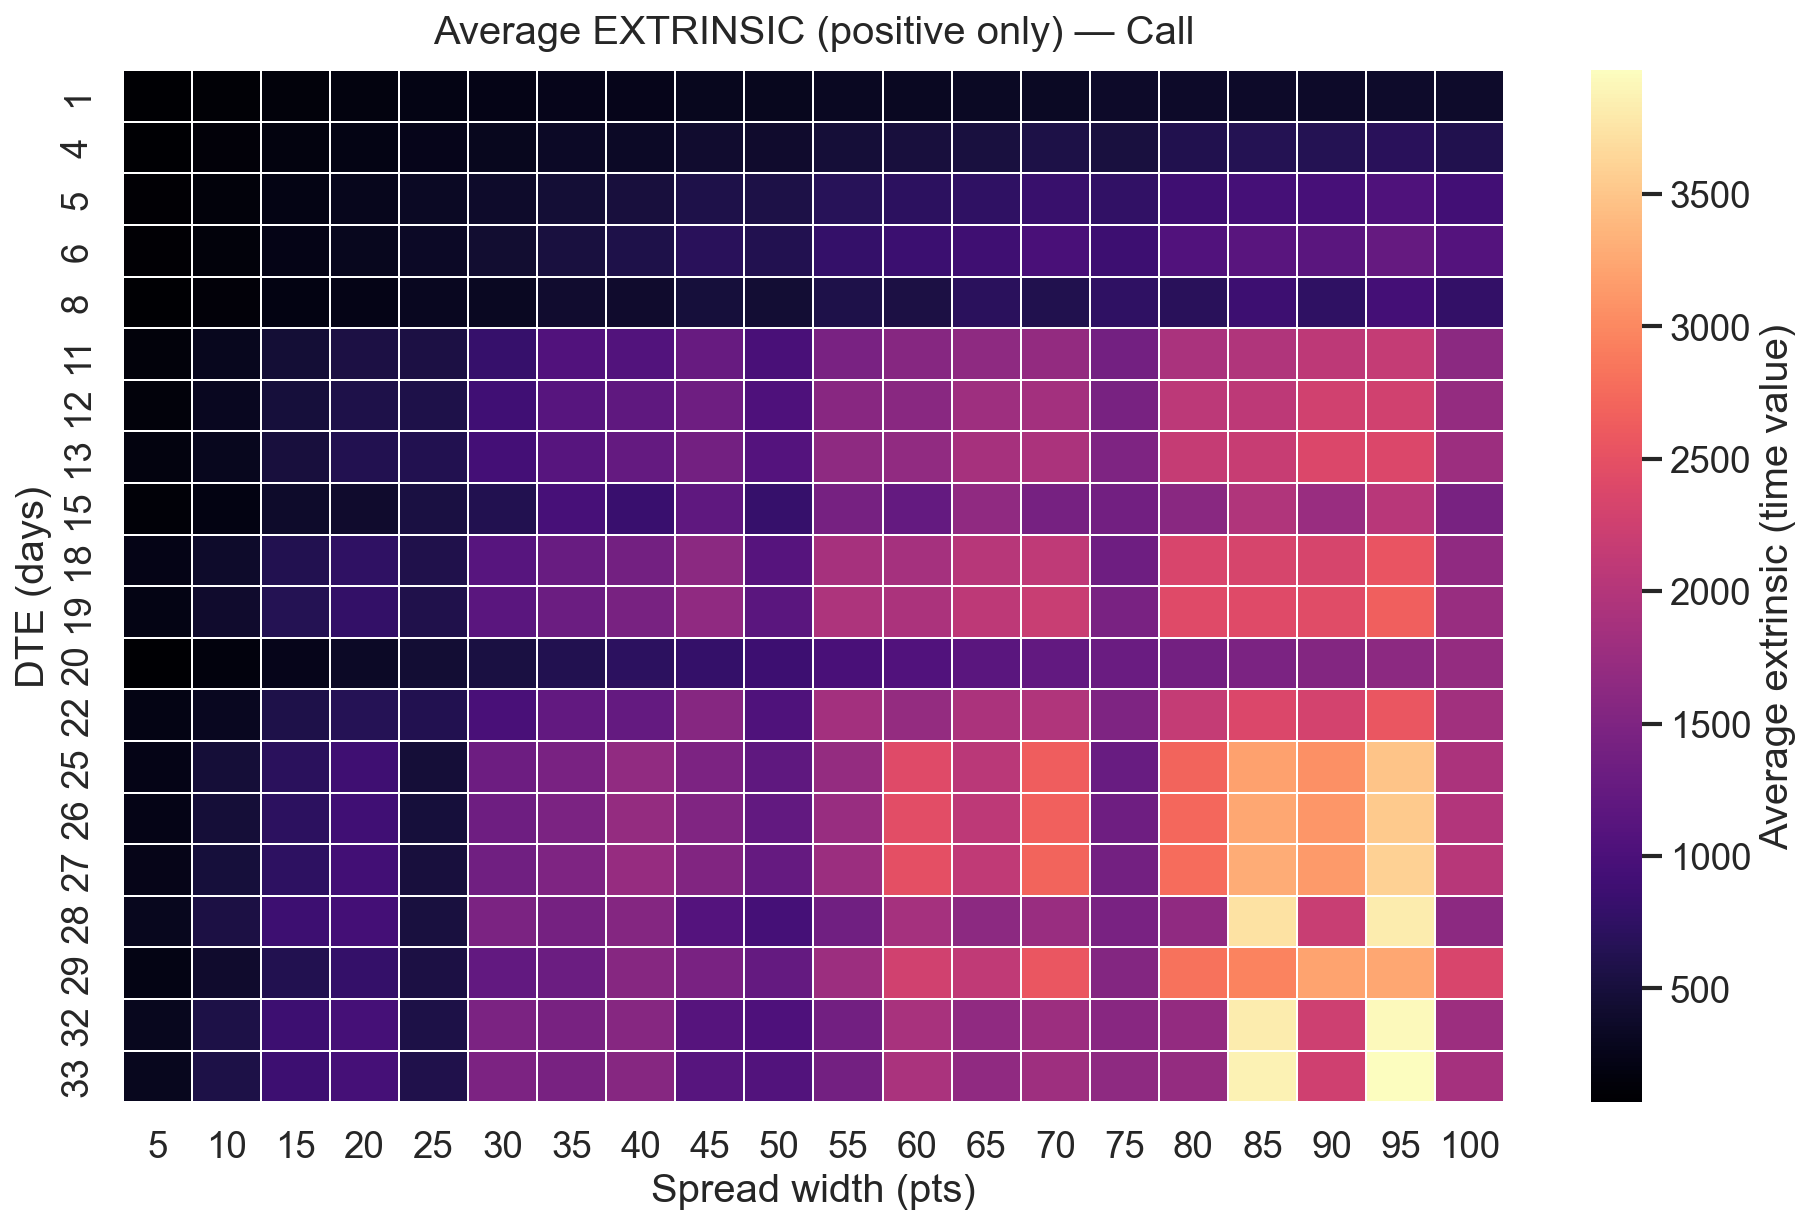

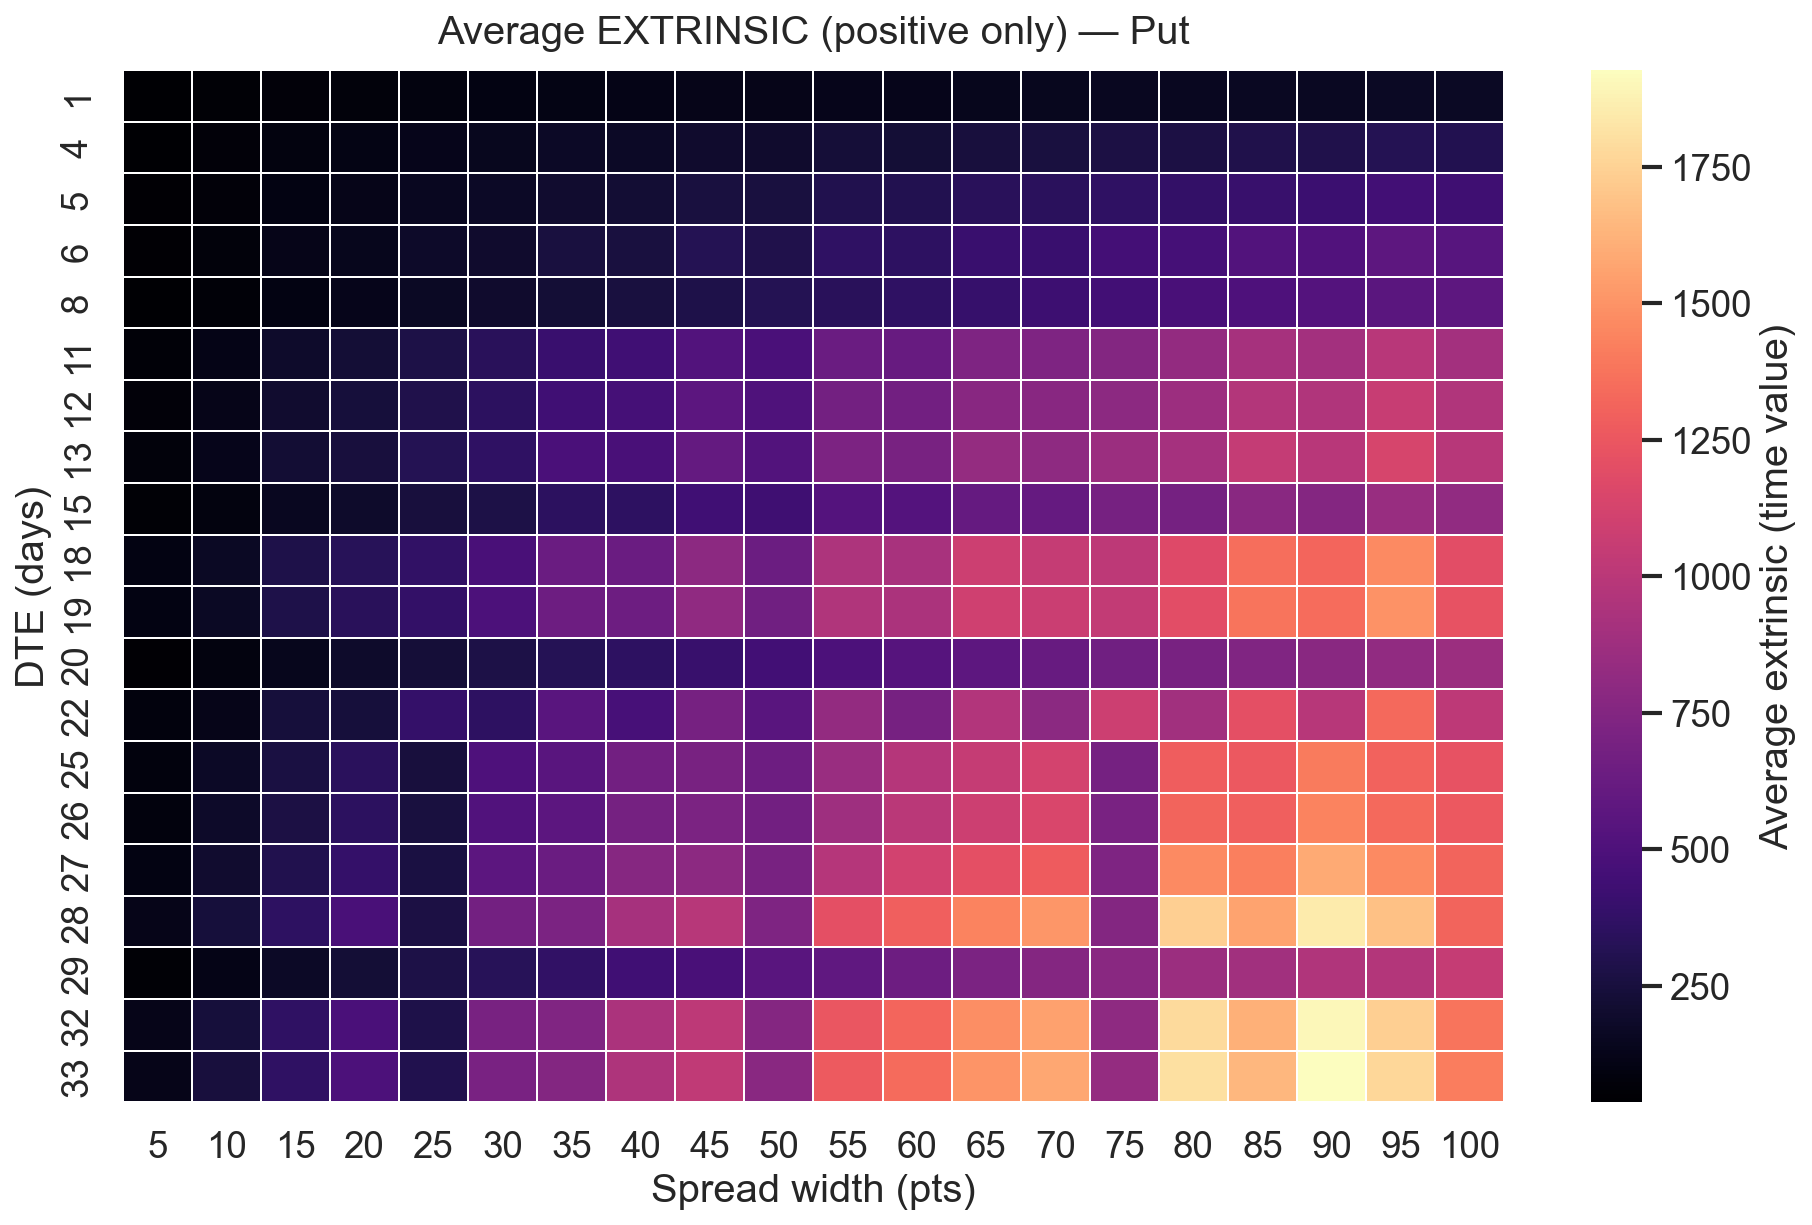

In [4]:

def avg_grid(df, type_value):
    sub = df[df["Type"] == type_value].copy()
    grid = sub.pivot_table(
        index="DTE", columns="SpreadWidthPts", values="EXTRINSIC", aggfunc="mean"
    )
    grid = grid.sort_index().sort_index(axis=1)
    return grid

types = df["Type"].dropna().unique().tolist()

def heatmap_grid(grid, title, cmap="viridis", save_name=None):
    if grid is None or grid.empty:
        print(f"[warn] empty grid: {title}")
        return
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(
        grid, cmap=cmap, linewidths=0.1, linecolor="white",
        cbar_kws={"label":"Average extrinsic (time value)"}
    )
    ax.set_title(title, pad=12)
    ax.set_xlabel("Spread width (pts)")
    ax.set_ylabel("DTE (days)")
    plt.tight_layout()
    if save_name:
        plt.savefig(SAVE_DIR / f"{save_name}.png", transparent=True)
    plt.show()

for t in types:
    grid = avg_grid(df, t)
    heatmap_grid(grid, f"Average EXTRINSIC (positive only) — {t}", cmap="magma",
                 save_name=f"avg_extrinsic_{t.lower()}")


In [6]:
df.describe()

Strike     Moneyness         Delta           DTE         WIDTH  \
count  39995.000000  39995.000000  39995.000000  39995.000000  39995.000000   
mean    6773.820728     -0.025432     -0.033484     13.196575     53.234779   
std      228.245568      0.026914      0.286969      8.309372     28.679222   
min     6200.000000     -0.099100     -0.986600      1.000000      5.000000   
25%     6620.000000     -0.041800     -0.200000      6.000000     30.000000   
50%     6805.000000     -0.020700     -0.042200     12.000000     55.000000   
75%     6920.000000     -0.006900      0.031100     20.000000     80.000000   
max     7550.000000      0.099800      0.999800     33.000000    100.000000   

          EXTRINSIC  SpreadWidthPts    StepNum  
count  3.999500e+04    39995.000000    39995.0  
mean   6.195699e+02       53.234779  10.646956  
std    7.910841e+02       28.679222   5.735844  
min    4.547474e-13        5.000000        1.0  
25%    5.500000e+01       30.000000        6.0  
50%    2.800000e+02       55.000000       11.0  
75%    9.100000e+02       80.000000       16.0  
max    5.250000e+03      100.000000       20.0

In [7]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil

sns.set_theme(style="white", context="talk")
plt.rcParams["figure.dpi"] = 160

# ---- Config ----
SPOT = 6901            # snapshot spot; adjust if needed
DTE_MAX = 33           # front-month window
STRIKE_MIN, STRIKE_MAX = 6200, 7600
BIN_WIDTH = 0.005      # 0.5% increments
KEEP_TYPES = ["Call", "Put"]  # ensure normalized types

# Normalize Type (handles C/P)
df["Type"] = (
    df["Type"].astype(str).str.strip().str.upper()
    .map({"C":"Call","CALL":"Call","P":"Put","PUT":"Put"})
    .fillna(df["Type"])
)

# Coerce numerics
for c in ["Strike","Moneyness","Delta","DTE","WIDTH","EXTRINSIC"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Filter window (front-month & strikes near spot)
f = df[
    (df["DTE"] >= 0) & (df["DTE"] <= DTE_MAX) &
    (df["Strike"] >= STRIKE_MIN) & (df["Strike"] <= STRIKE_MAX) &
    df["Type"].isin(KEEP_TYPES) &
    df["EXTRINSIC"].notna() & (df["EXTRINSIC"] > 0)
].copy()

# Compute moneyness %:
# If df["Moneyness"] is already percent (e.g., +/-0.03), use it; else derive from Strike and SPOT.
# We'll detect scale heuristically.
if f["Moneyness"].abs().max() > 2:  # likely raw points, not percent
    f["moneyness_pct"] = (f["Strike"] - SPOT) / SPOT
else:
    f["moneyness_pct"] = f["Moneyness"]  # already in fraction form

# Build 0.5% bins spanning the data
mn, mx = f["moneyness_pct"].min(), f["moneyness_pct"].max()
lo = floor(mn / BIN_WIDTH) * BIN_WIDTH
hi = ceil(mx / BIN_WIDTH) * BIN_WIDTH
bin_edges = np.arange(lo, hi + BIN_WIDTH, BIN_WIDTH)

# Label bins as % strings (e.g., -2.5%..-2.0%)
labels = [f"{int(left*1000)/10:.1f}% to {int(right*1000)/10:.1f}%"
          for left, right in zip(bin_edges[:-1], bin_edges[1:])]

f["moneyness_bin"] = pd.cut(f["moneyness_pct"], bins=bin_edges, labels=labels, include_lowest=True)

print("Rows after filter:", len(f))
print("Moneyness % range:", mn, "→", mx)
print("Bin count:", len(labels))


Rows after filter: 39995
Moneyness % range: -0.0991 → 0.0998
Bin count: 40


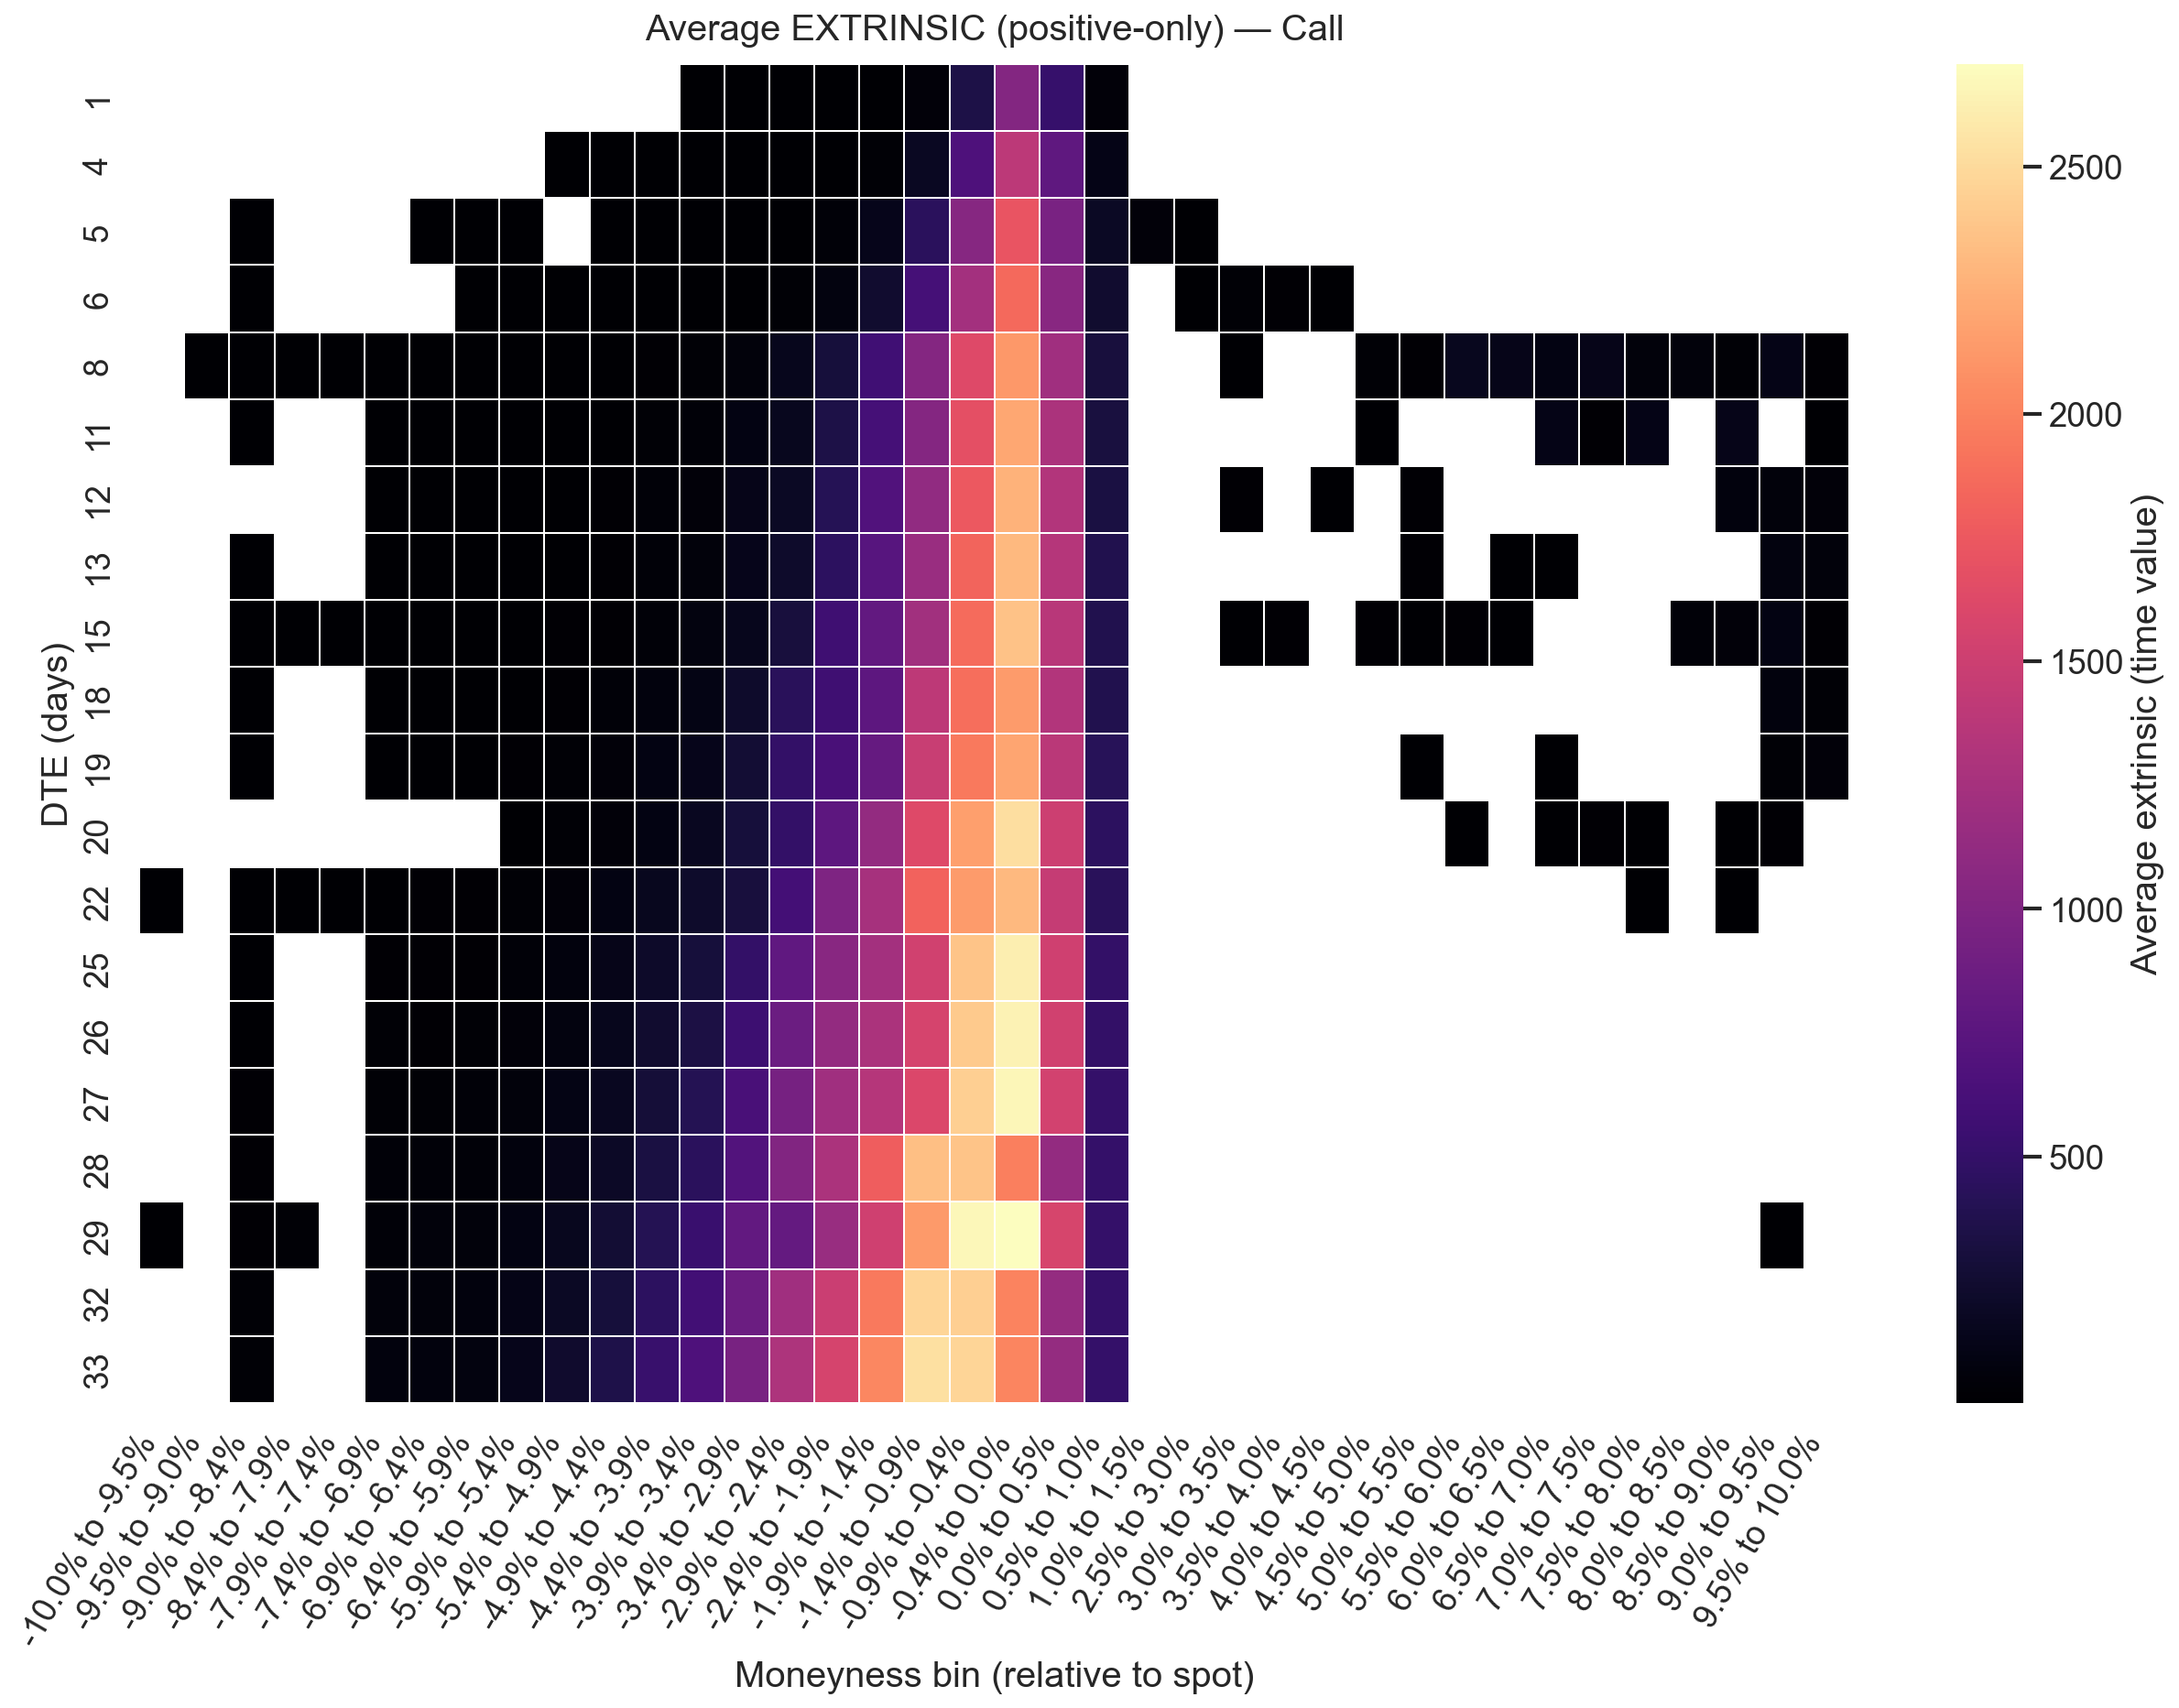

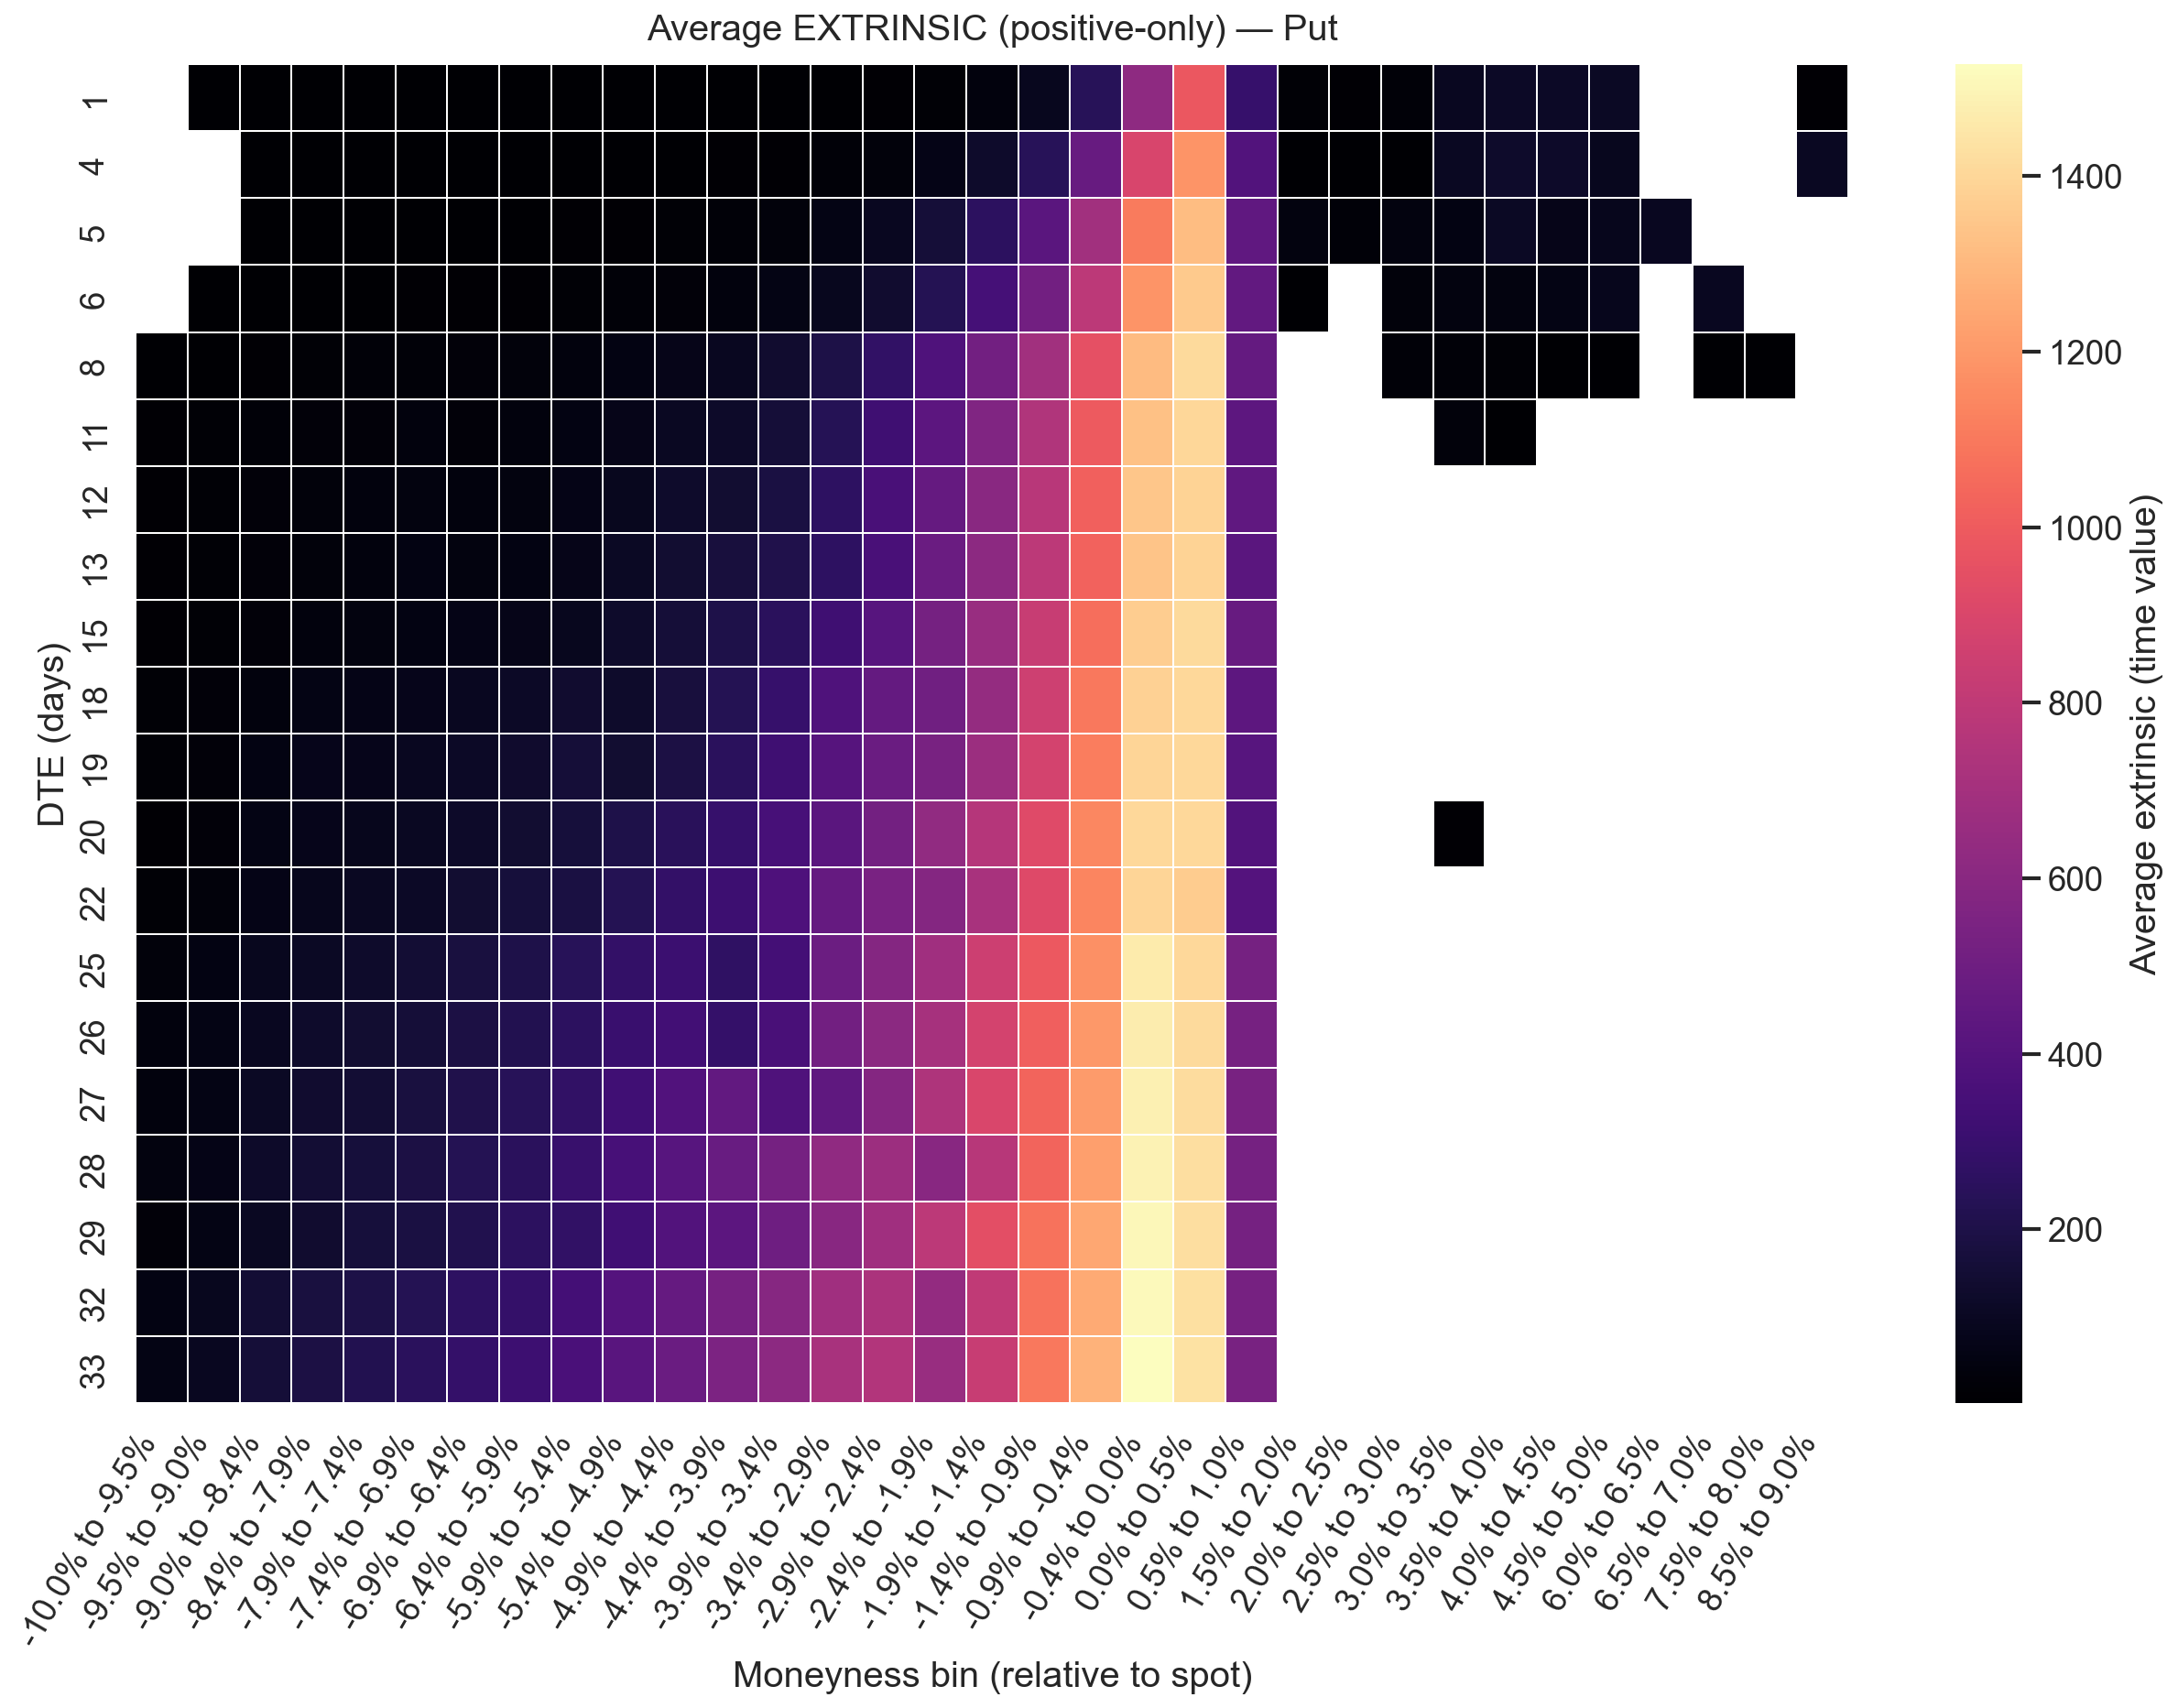

In [8]:

def sort_bins_numerically(bin_labels):
    # Sort labels by their left-edge percentage
    def left_val(lbl):
        # lbl like "-2.5% to -2.0%" → take first token before '%'
        return float(lbl.split('%')[0])
    return sorted(bin_labels, key=left_val)

def avg_grid_by_type(df_sub, type_value):
    sub = df_sub[df_sub["Type"] == type_value].copy()
    grid = sub.pivot_table(index="DTE", columns="moneyness_bin",
                           values="EXTRINSIC", aggfunc="mean")
    grid = grid.sort_index()  # DTE ascending
    # Reorder columns by numeric left-edge
    ordered_cols = sort_bins_numerically([c for c in grid.columns if pd.notna(c)])
    grid = grid[ordered_cols]
    return grid

types = f["Type"].dropna().unique().tolist()
for t in types:
    grid = avg_grid_by_type(f, t)
    plt.figure(figsize=(16, 12))
    ax = sns.heatmap(
        grid, cmap="magma", linewidths=0.1, linecolor="white",
        cbar_kws={"label":"Average extrinsic (time value)"}
    )
    ax.set_title(f"Average EXTRINSIC (positive-only) — {t}", pad=12)
    ax.set_xlabel("Moneyness bin (relative to spot)")
    ax.set_ylabel("DTE (days)")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()


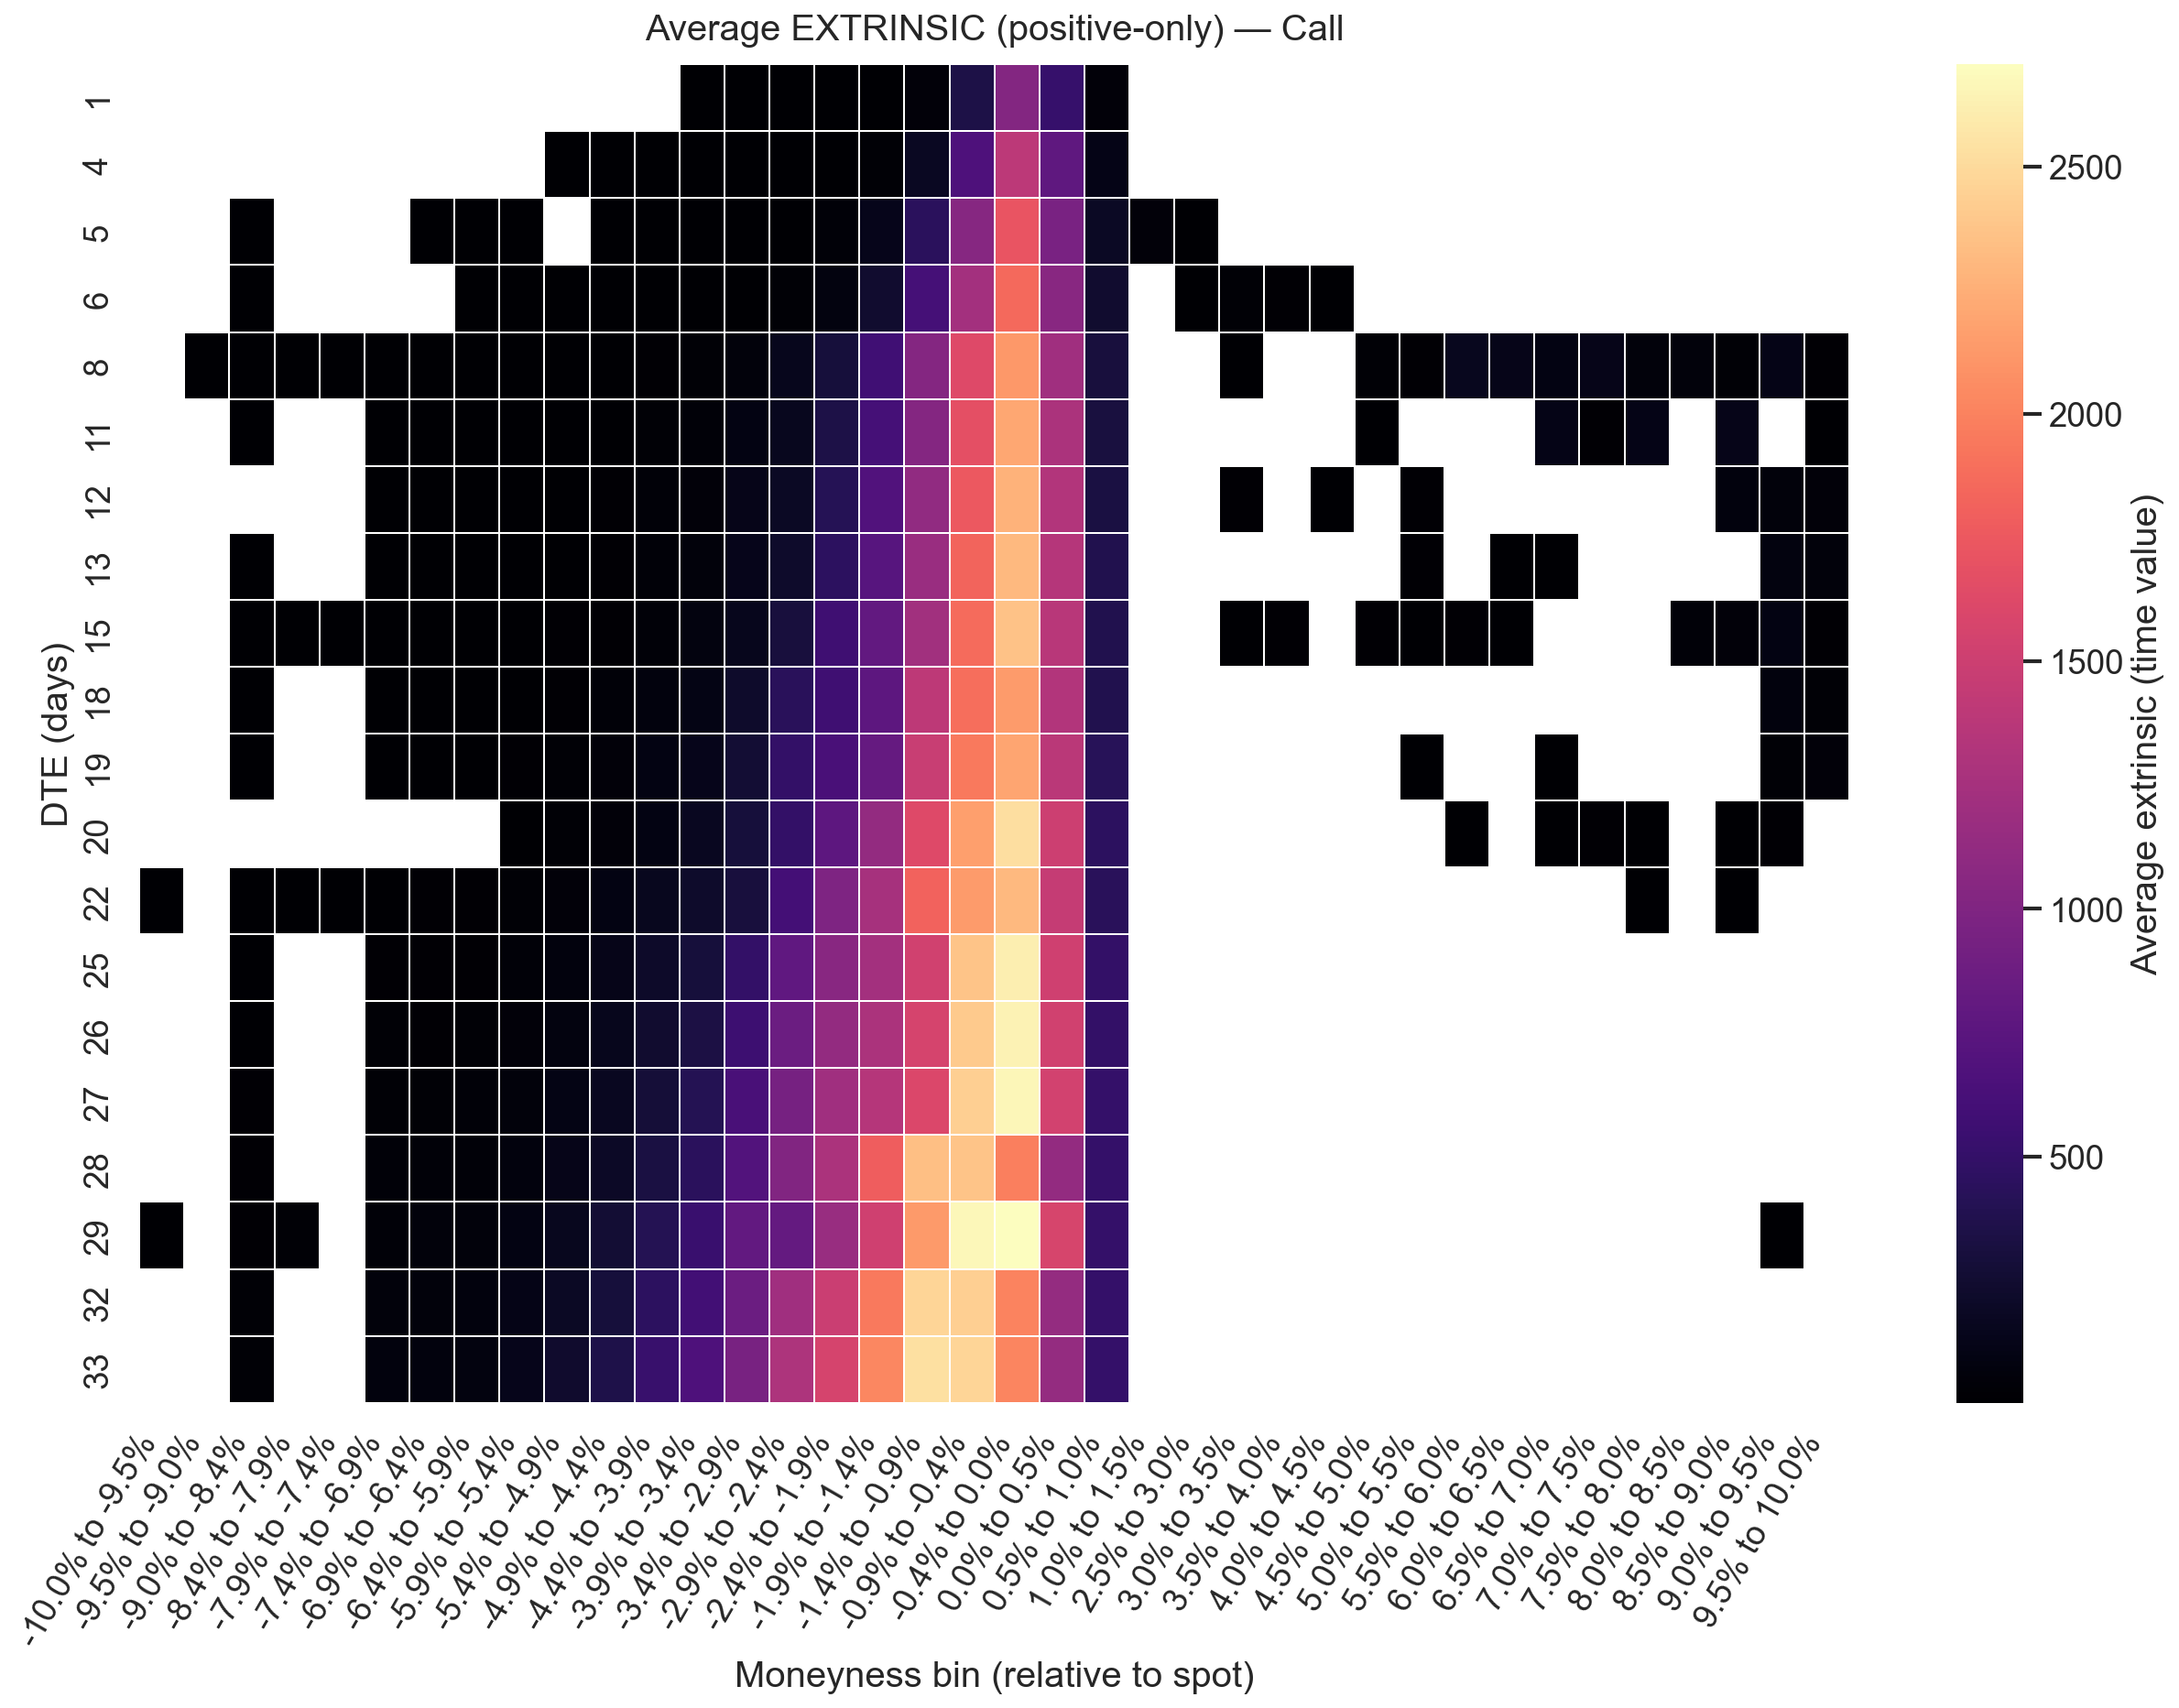

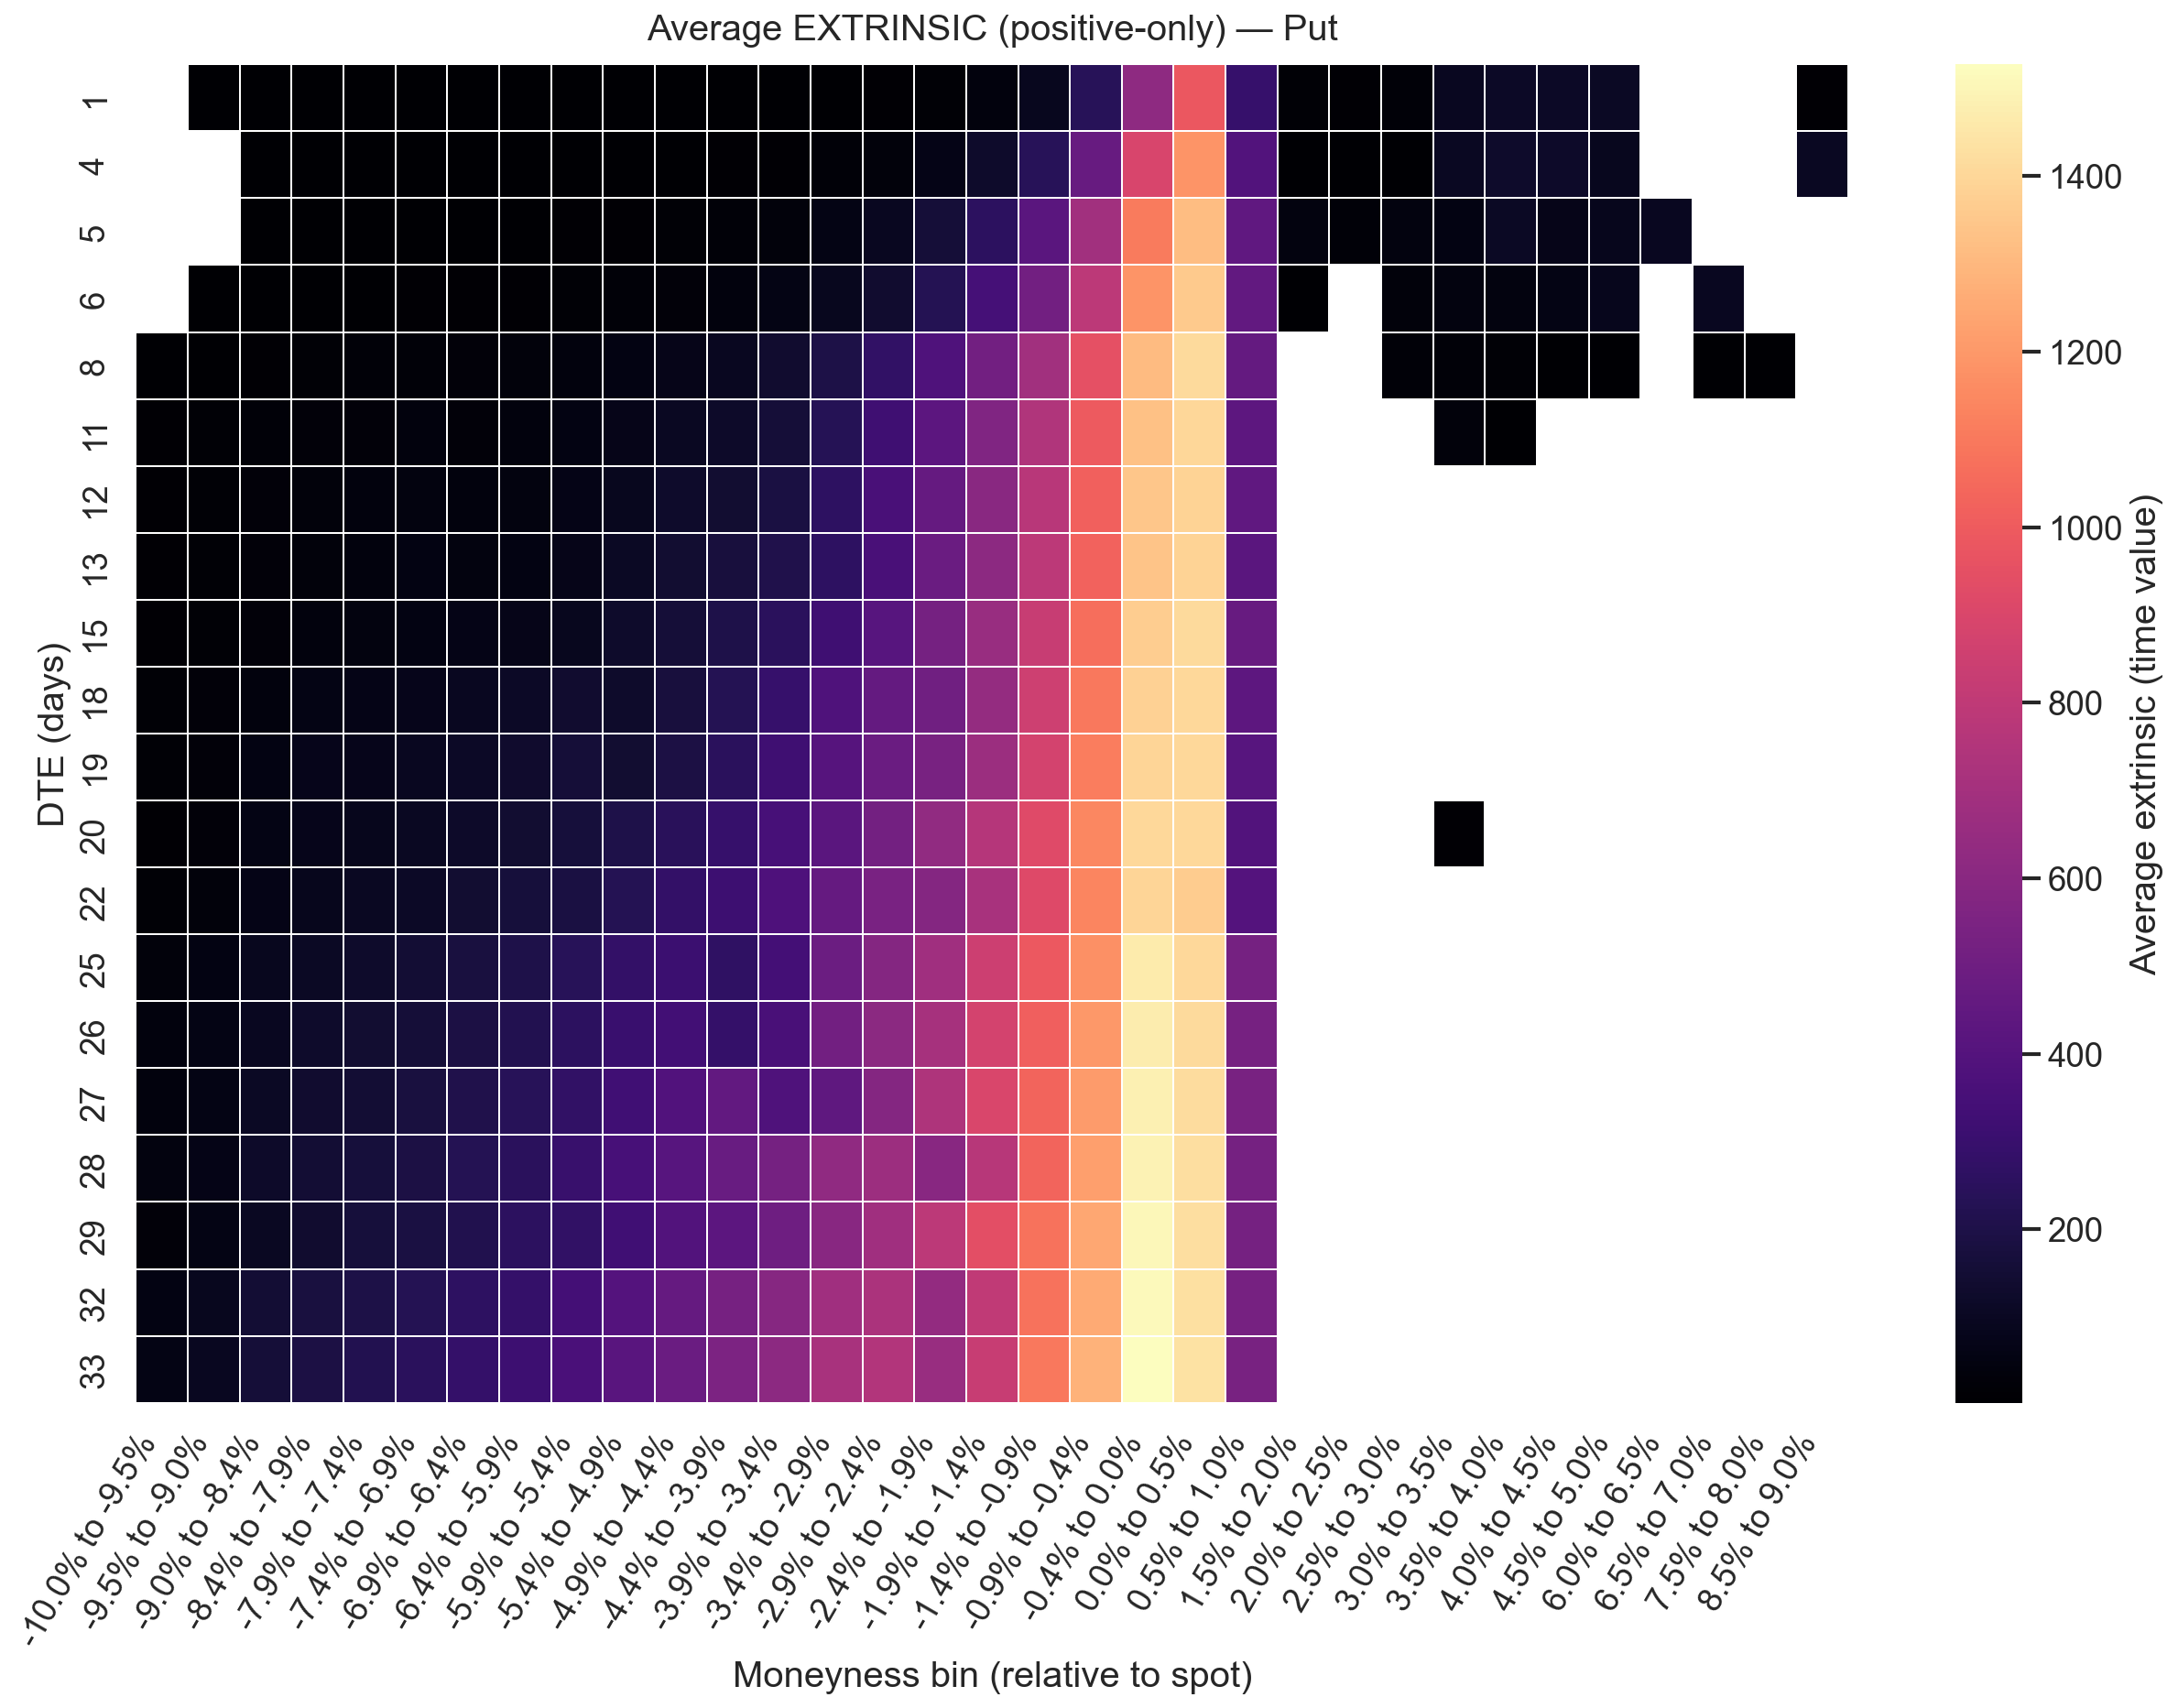

In [9]:

def sort_bins_numerically(bin_labels):
    # Sort labels by their left-edge percentage
    def left_val(lbl):
        # lbl like "-2.5% to -2.0%" → take first token before '%'
        return float(lbl.split('%')[0])
    return sorted(bin_labels, key=left_val)

def avg_grid_by_type(df_sub, type_value):
    sub = df_sub[df_sub["Type"] == type_value].copy()
    grid = sub.pivot_table(index="DTE", columns="moneyness_bin",
                           values="EXTRINSIC", aggfunc="mean")
    grid = grid.sort_index()  # DTE ascending
    # Reorder columns by numeric left-edge
    ordered_cols = sort_bins_numerically([c for c in grid.columns if pd.notna(c)])
    grid = grid[ordered_cols]
    return grid

types = f["Type"].dropna().unique().tolist()
for t in types:
    grid = avg_grid_by_type(f, t)
    plt.figure(figsize=(16, 12))
    ax = sns.heatmap(
        grid, cmap="magma", linewidths=0.1, linecolor="white",
        cbar_kws={"label":"Average extrinsic (time value)"}
    )
    ax.set_title(f"Average EXTRINSIC (positive-only) — {t}", pad=12)
    ax.set_xlabel("Moneyness bin (relative to spot)")
    ax.set_ylabel("DTE (days)")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()


In [10]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 160
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

# Normalize Type values (handles C/P)
df["Type"] = (
    df["Type"].astype(str).str.strip().str.upper()
    .map({"C":"Call","CALL":"Call","P":"Put","PUT":"Put"})
    .fillna(df["Type"])
)

# Coerce numerics defensively
for c in ["Strike","Moneyness","Delta","DTE","WIDTH","EXTRINSIC"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep valid rows: positive extrinsic (already filtered) and WIDTH > 0
clean = df[
    df["EXTRINSIC"].notna() & (df["EXTRINSIC"] > 0) &
    df["WIDTH"].notna() & (df["WIDTH"] > 0) &
    df["Type"].isin(["Call","Put"])
].copy()

# Compute the metric
clean["TV_per_Unit"] = clean["EXTRINSIC"] / clean["WIDTH"]

print("Rows in analysis:", len(clean))
print("Width range:", clean["WIDTH"].min(), "→", clean["WIDTH"].max())
print("TV_per_Unit range:", clean["TV_per_Unit"].min(), "→", clean["TV_per_Unit"].max())


Rows in analysis: 39995
Width range: 5 → 100
TV_per_Unit range: 5.052748343182935e-15 → 60.5


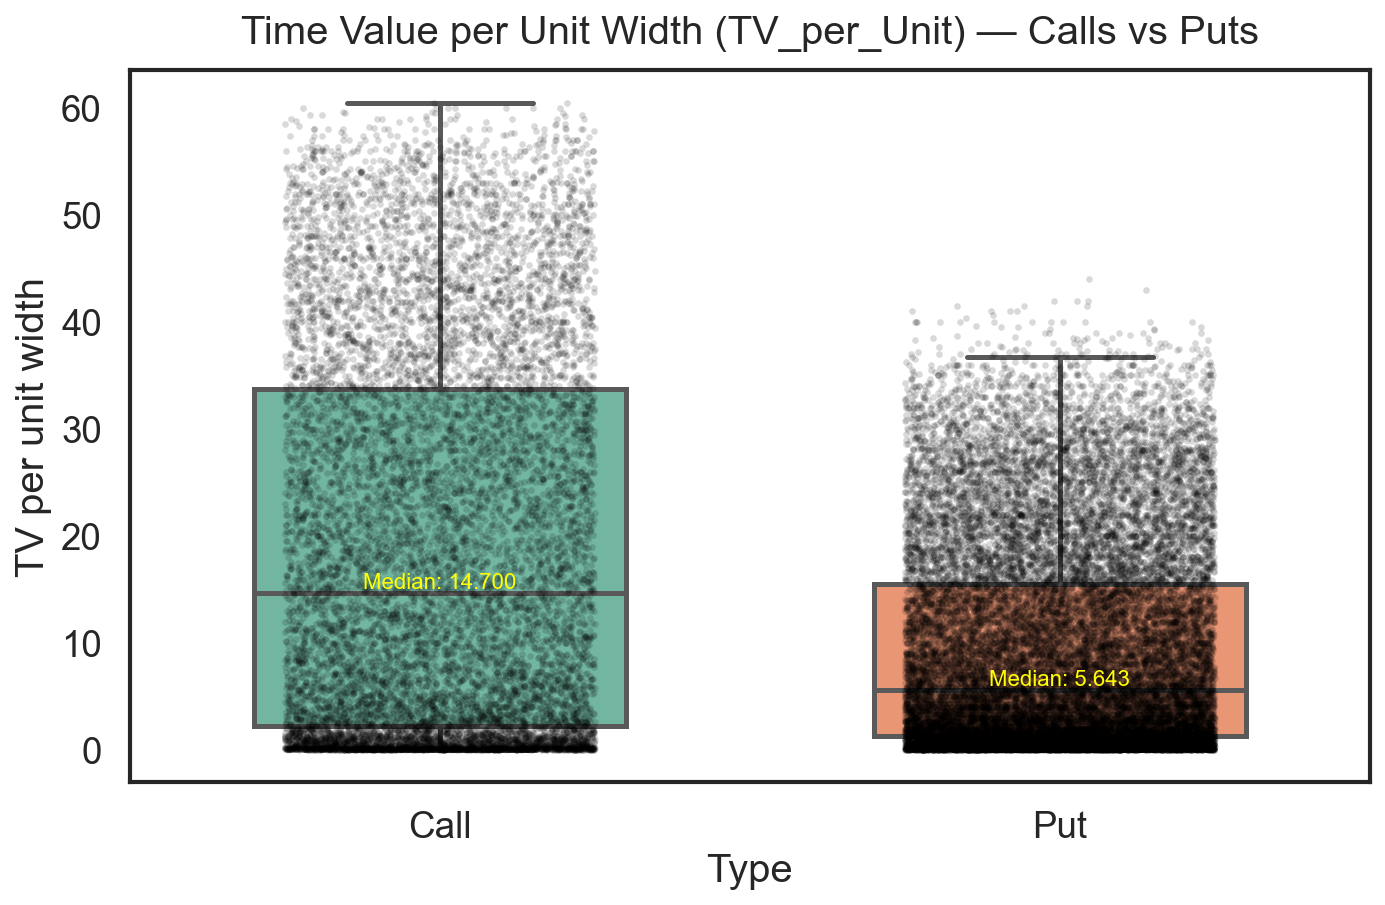

In [17]:

plt.figure(figsize=(9,6))
ax = sns.boxplot(
    data=clean,
    x="Type", y="TV_per_Unit",
    showfliers=False,  # hide extreme outliers so medians/IQR are clearer
    width=0.6, palette="Set2"
)

# Optional: overlay a light jittered scatter for density sense
sns.stripplot(
    data=clean, x="Type", y="TV_per_Unit",
    color="black", alpha=0.15, size=3, jitter=0.25
)

# Annotate medians
meds = clean.groupby("Type")["TV_per_Unit"].median()
for i, t in enumerate(meds.index):
    ax.text(i, meds.loc[t], f"Median: {meds.loc[t]:.3f}", ha="center", va="bottom", fontsize=10, color="yellow")

ax.set_title("Time Value per Unit Width (TV_per_Unit) — Calls vs Puts", pad=12)
ax.set_xlabel("Type")
ax.set_ylabel("TV per unit width")
plt.tight_layout()
plt.savefig(SAVE_DIR / "boxplot_tv_per_unit_by_type.png", transparent=True)
plt.show()


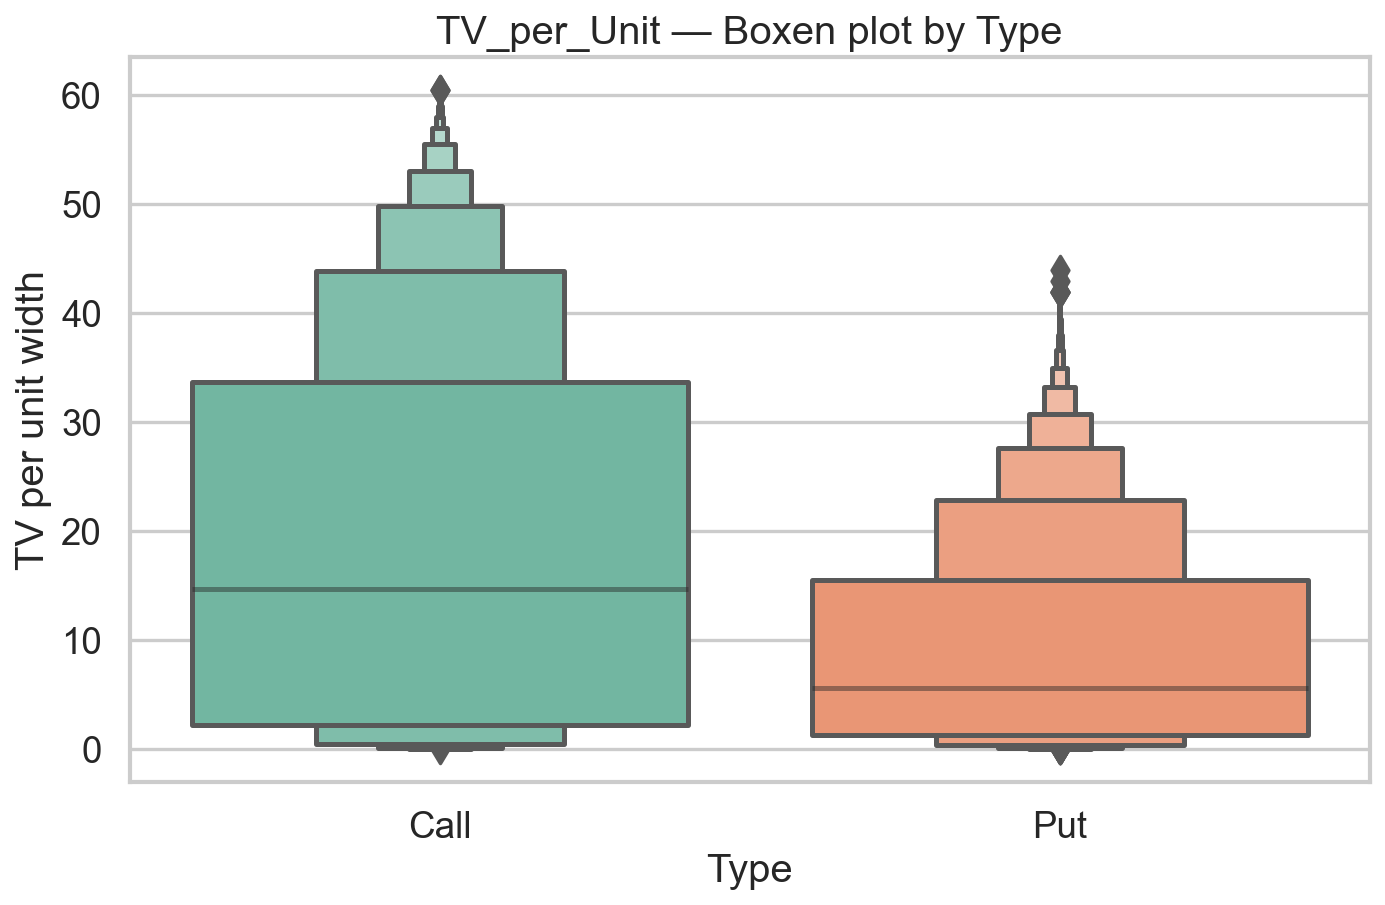

In [12]:

plt.figure(figsize=(9,6))
sns.boxenplot(
    data=clean, x="Type", y="TV_per_Unit", palette="Set2"
)
plt.title("TV_per_Unit — Boxen plot by Type")
plt.xlabel("Type"); plt.ylabel("TV per unit width")
plt.tight_layout()
plt.savefig(SAVE_DIR / "boxen_tv_per_unit_by_type.png", transparent=True)
plt.show()



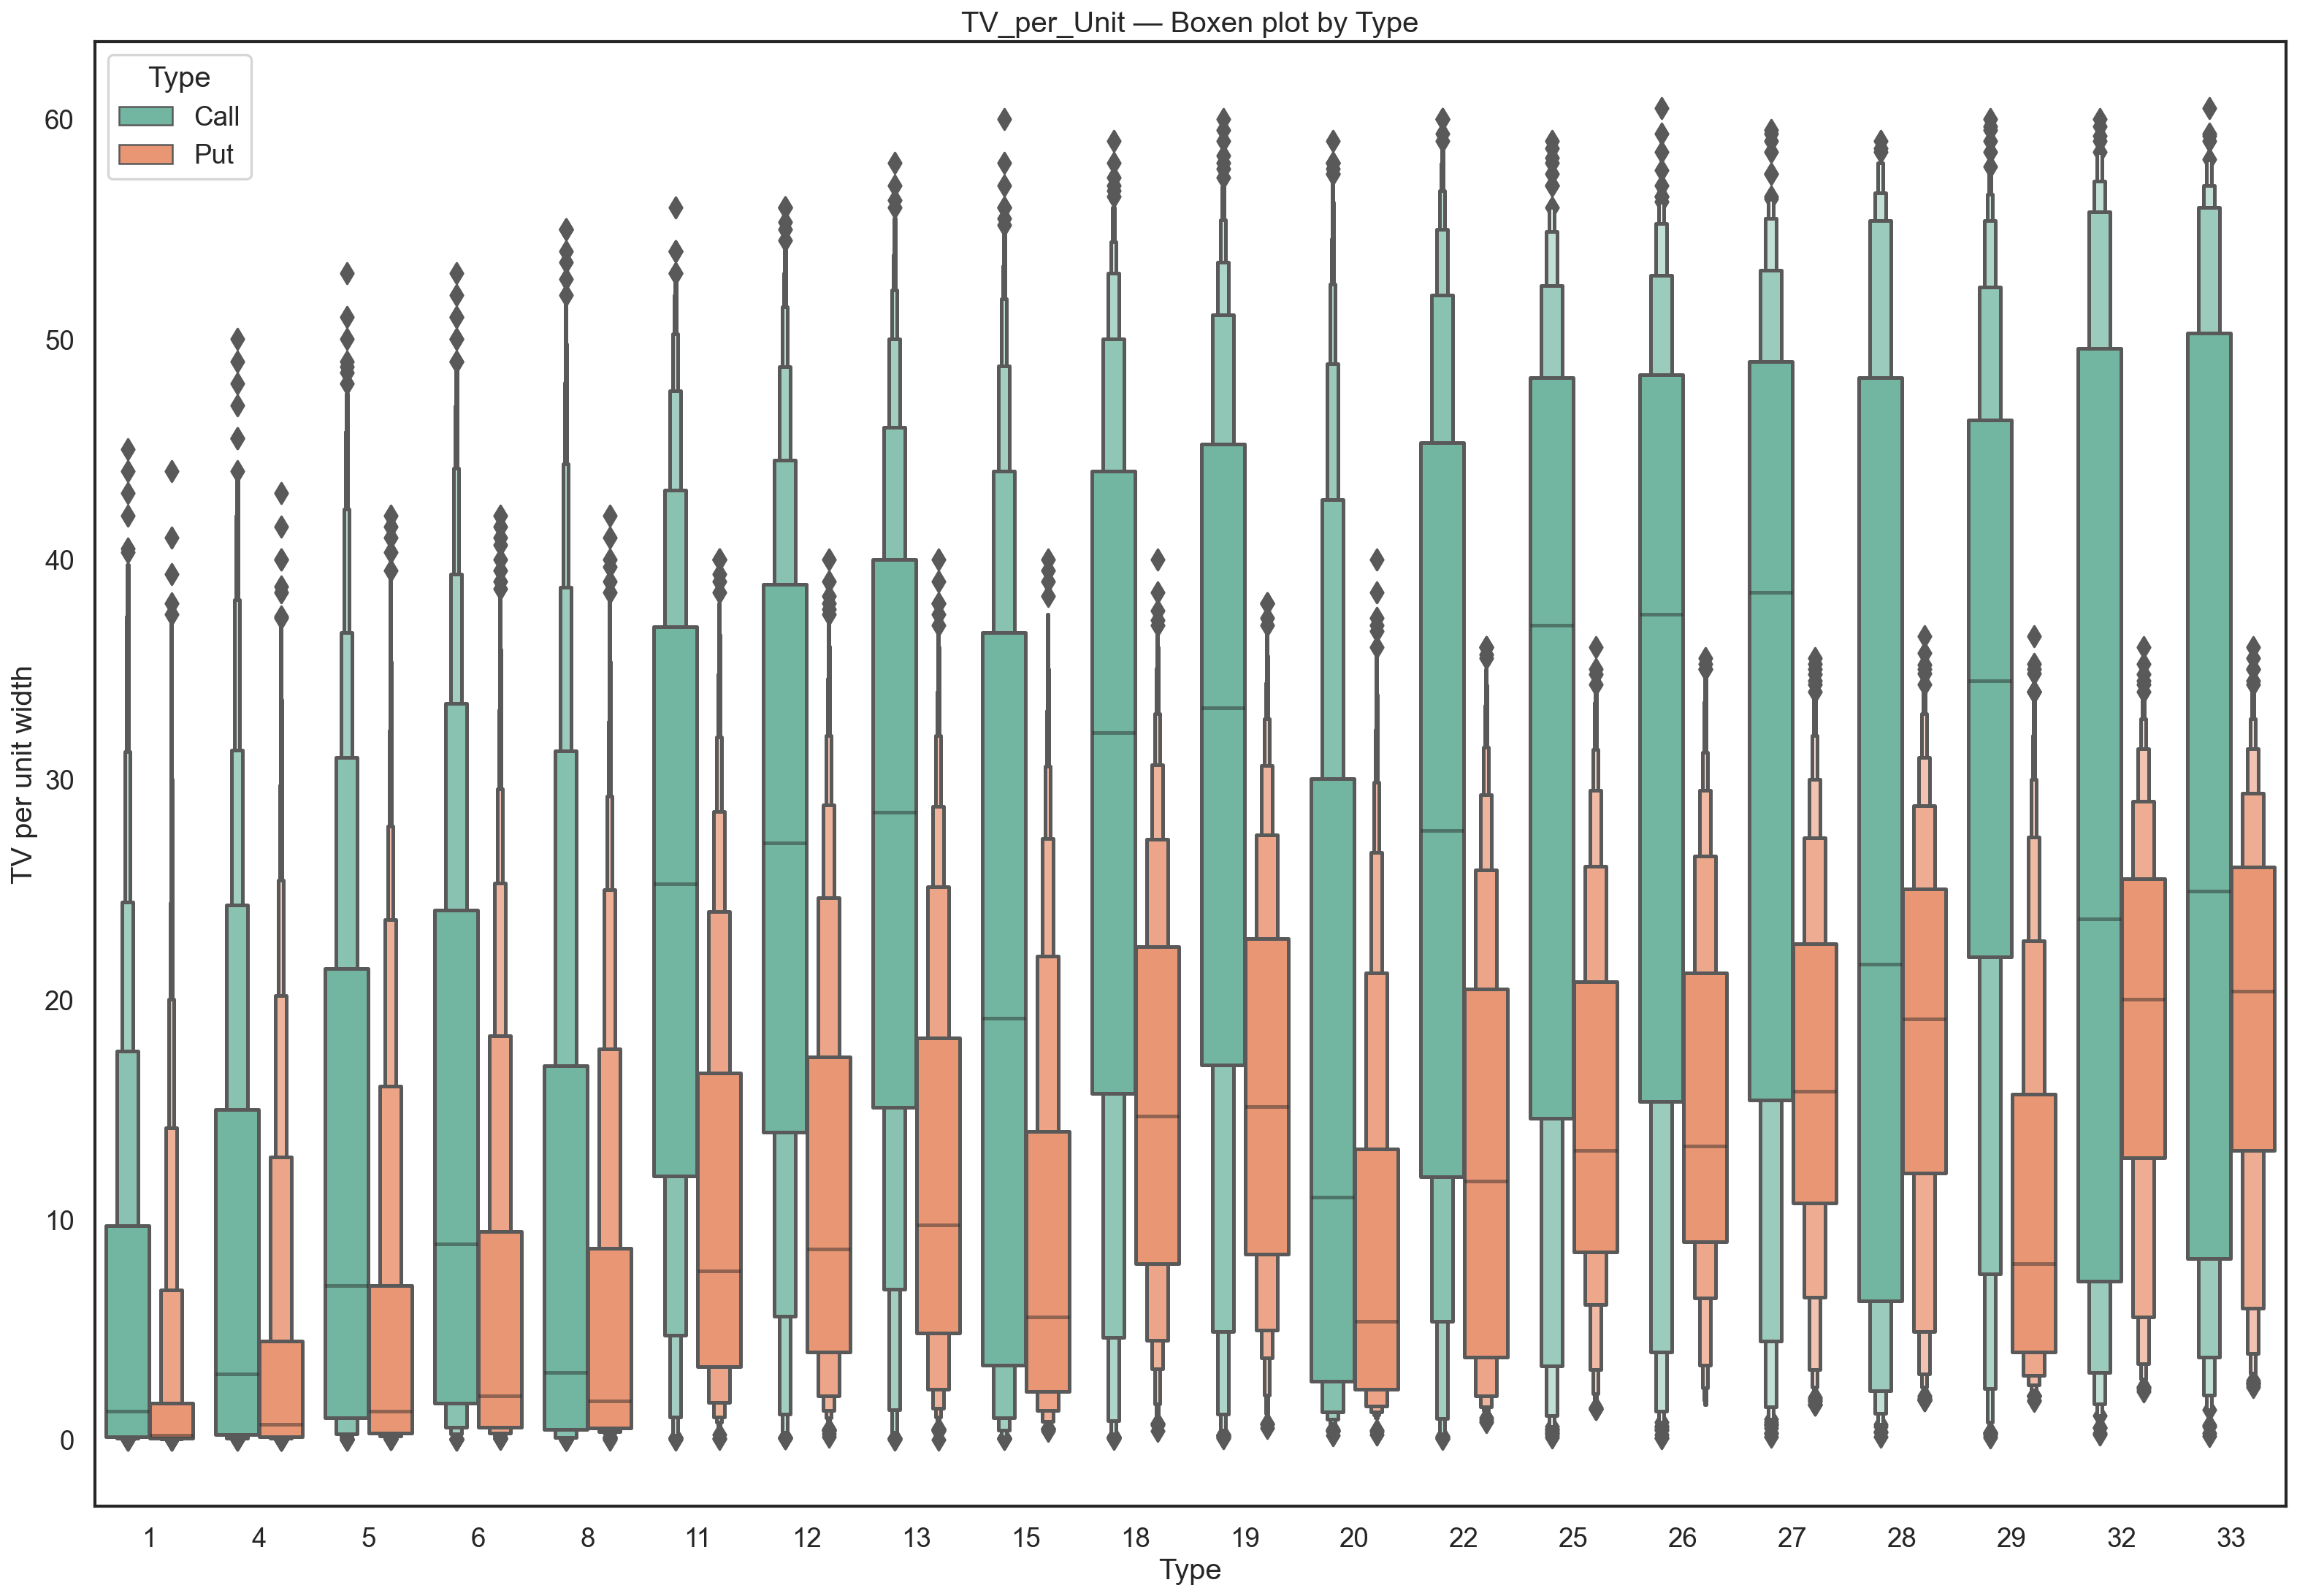

In [23]:

plt.figure(figsize=(20,14))
sns.boxenplot(
    data=clean, hue="Type", y="TV_per_Unit", palette="Set2", x = "DTE"
)
plt.title("TV_per_Unit — Boxen plot by Type")
plt.xlabel("Type"); plt.ylabel("TV per unit width")
plt.tight_layout()
plt.show()



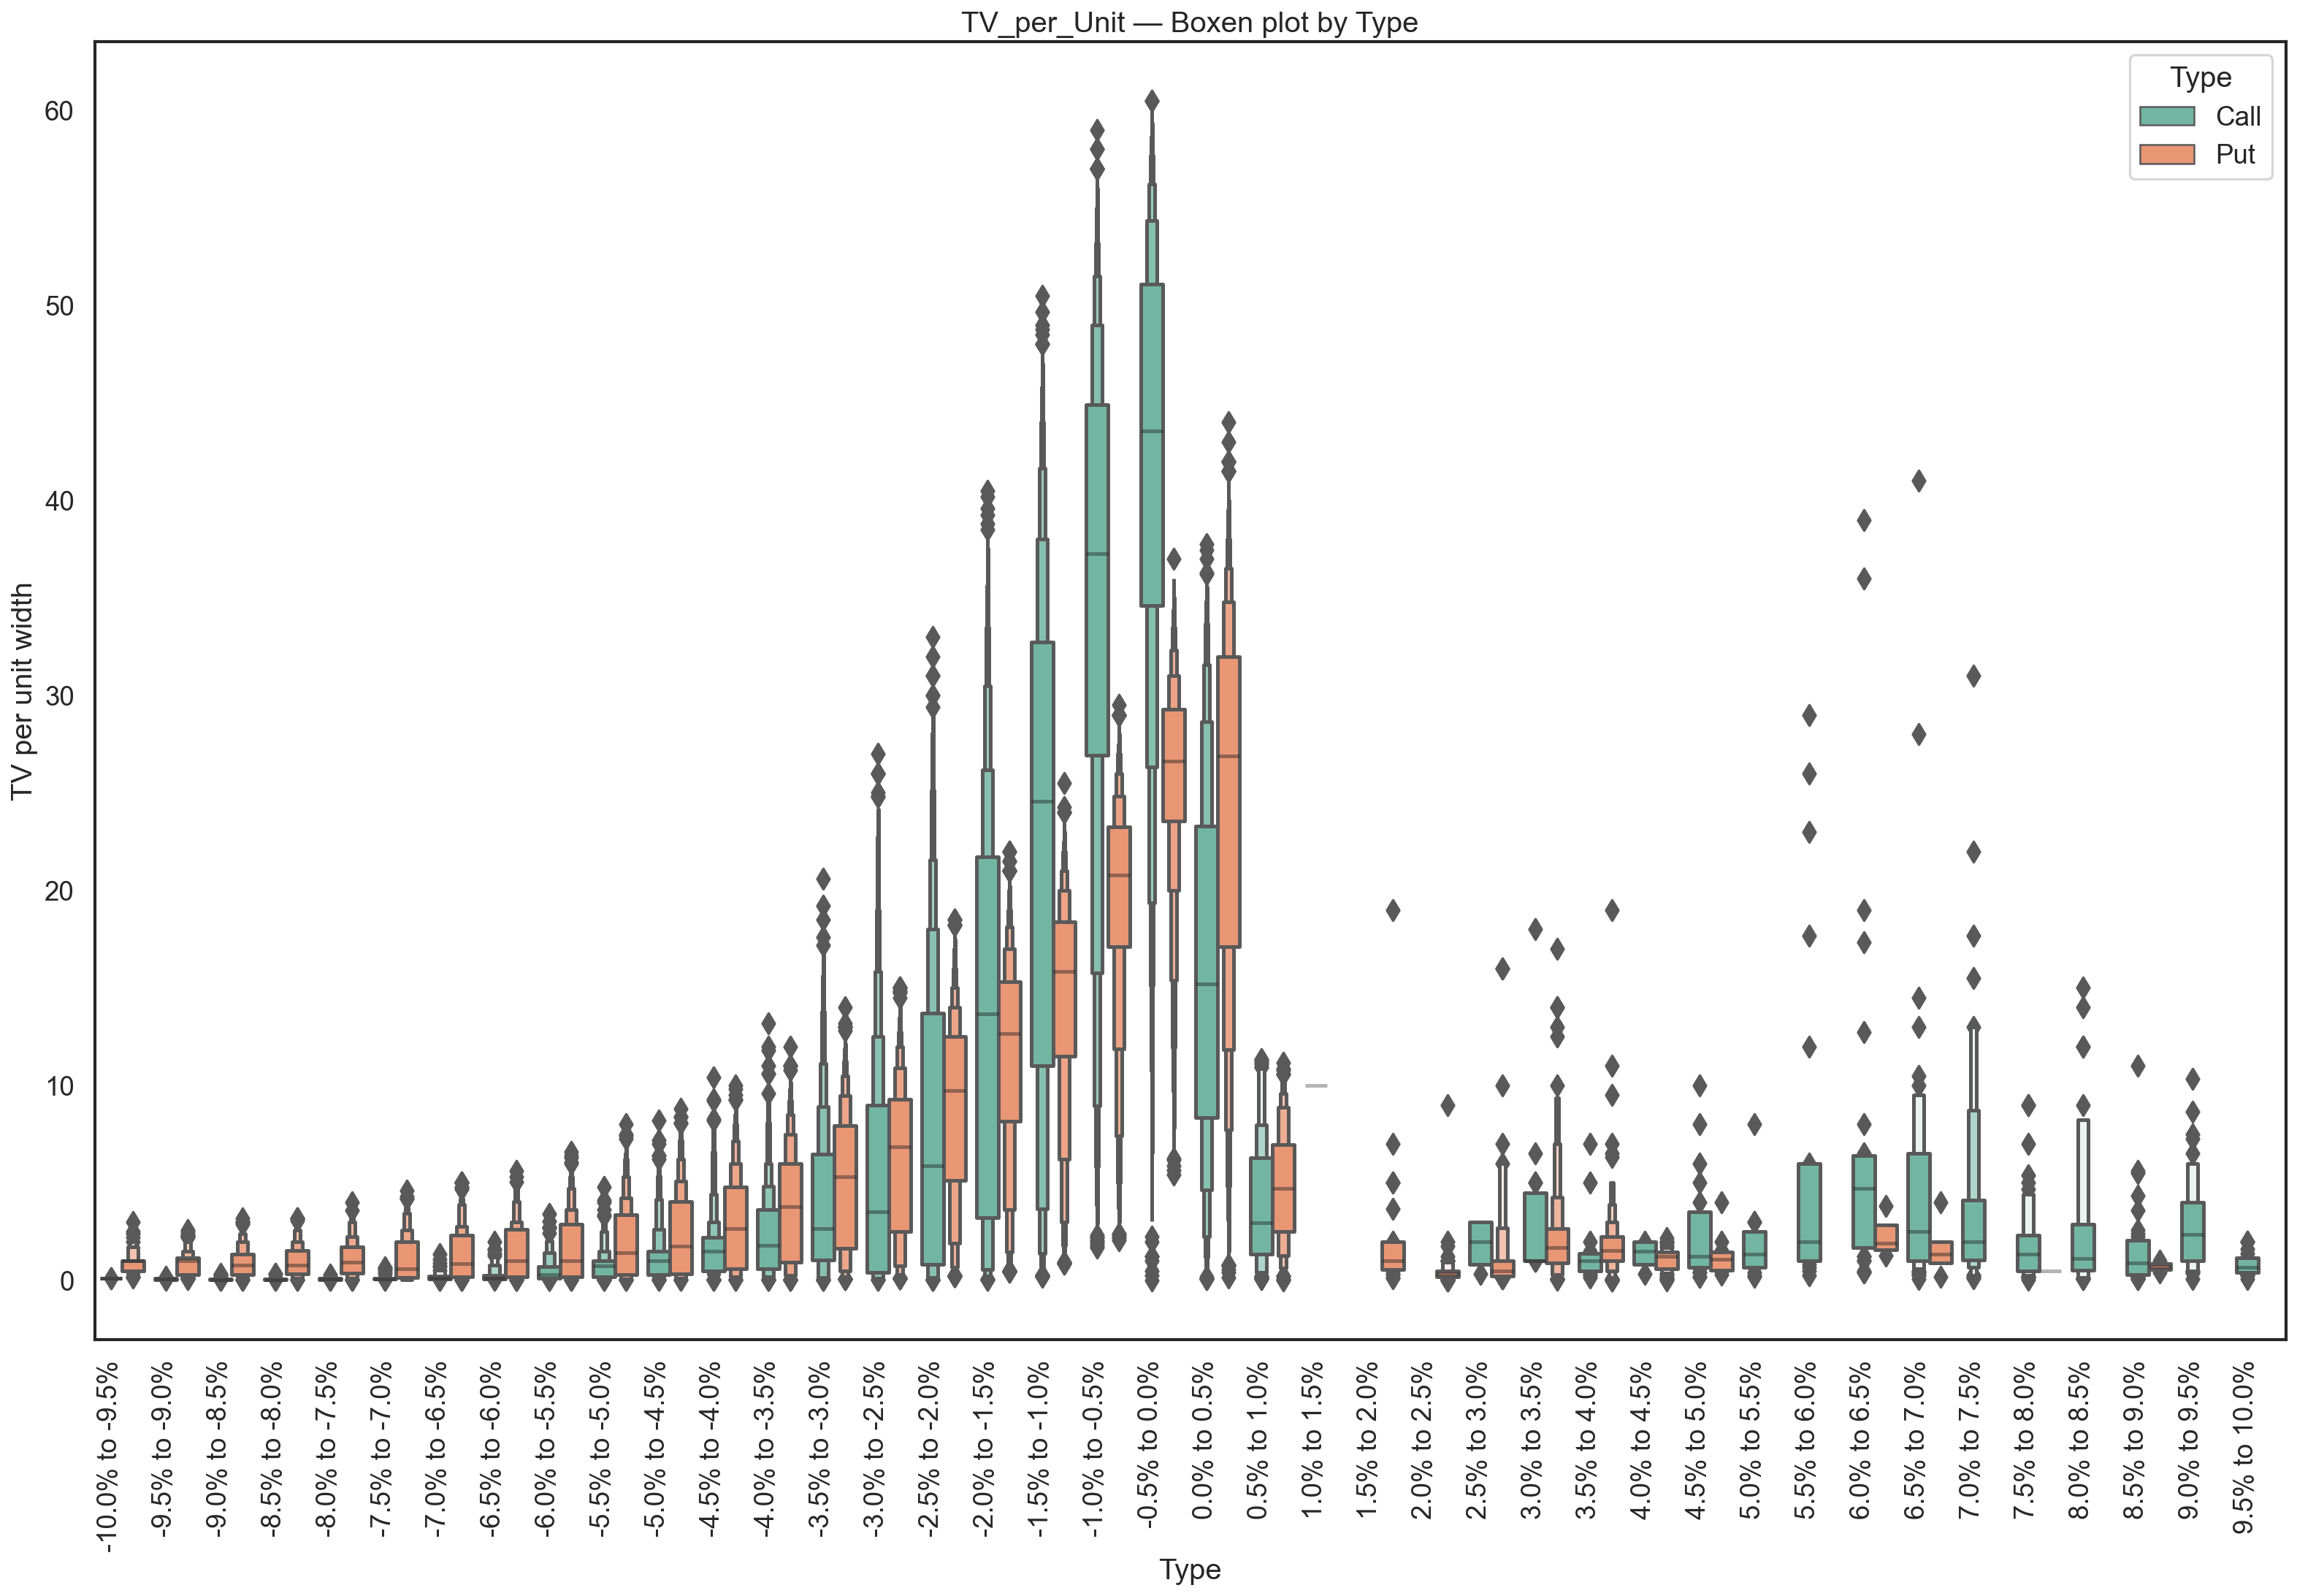

In [25]:

plt.figure(figsize=(20,14))
sns.boxenplot(
    data=f, hue="Type", y="TV_per_Unit", palette="Set2", x = "moneyness_bin"
)
plt.title("TV_per_Unit — Boxen plot by Type")
plt.xlabel("Type"); plt.ylabel("TV per unit width")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()



In [27]:
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39995 entries, 0 to 39994
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Strike           39995 non-null  int64   
 1   Moneyness        39995 non-null  float64 
 2   Delta            39995 non-null  float64 
 3   Type             39995 non-null  object  
 4   DTE              39995 non-null  int64   
 5   WIDTH            39995 non-null  int64   
 6   EXTRINSIC        39995 non-null  float64 
 7   SpreadWidthPts   39995 non-null  int64   
 8   StepNum          39995 non-null  Int64   
 9   TV_per_Unit      39995 non-null  float64 
 10  moneyness_bin    39995 non-null  category
 11  TV_per_Unit_day  39995 non-null  float64 
 12  _DTE_bin         39995 non-null  category
dtypes: Int64(1), category(2), float64(5), int64(4), object(1)
memory usage: 3.5+ MB


In [14]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil

sns.set_theme(style="white", context="talk")
plt.rcParams["figure.dpi"] = 160

# ---- Config ----
DTE_MAX = 33                     # front-month window
STRIKE_MIN, STRIKE_MAX = 6200, 7600
BIN_WIDTH = 0.005                # 0.5% increments
KEEP_TYPES = ["Call", "Put"]
AGG = "mean"                     # choose "mean" or "median"
MIN_COUNT = 20                   # mask cells with fewer than N observations

# Normalize Type
df["Type"] = (
    df["Type"].astype(str).str.strip().str.upper()
    .map({"C":"Call","CALL":"Call","P":"Put","PUT":"Put"})
    .fillna(df["Type"])
)

# Coerce numerics
for c in ["Strike","Moneyness","Delta","DTE","WIDTH","EXTRINSIC"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Filter window and valid rows
f = df[
    (df["DTE"] >= 0) & (df["DTE"] <= DTE_MAX) &
    (df["Strike"] >= STRIKE_MIN) & (df["Strike"] <= STRIKE_MAX) &
    df["Type"].isin(KEEP_TYPES) &
    df["EXTRINSIC"].notna() & (df["EXTRINSIC"] > 0) &
    df["WIDTH"].notna() & (df["WIDTH"] > 0)
].copy()

# New metric: time value per unit width
f["TV_per_Unit"] = f["EXTRINSIC"] / f["WIDTH"]

# Moneyness is already a fraction (≈ -0.099 to +0.100)
mn, mx = f["Moneyness"].min(), f["Moneyness"].max()
lo = floor(mn / BIN_WIDTH) * BIN_WIDTH
hi = ceil(mx / BIN_WIDTH) * BIN_WIDTH
bin_edges = np.arange(lo, hi + BIN_WIDTH, BIN_WIDTH)

# Bin labels like "-2.5% to -2.0%"
labels = [f"{left*100:.1f}% to {right*100:.1f}%"
          for left, right in zip(bin_edges[:-1], bin_edges[1:])]

f["moneyness_bin"] = pd.cut(
    f["Moneyness"], bins=bin_edges, labels=labels, include_lowest=True
)

print("Rows after filter:", len(f))
print("Moneyness fraction range:", mn, "→", mx)
print("Bin count:", len(labels))


Rows after filter: 39995
Moneyness fraction range: -0.0991 → 0.0998
Bin count: 40


In [15]:

def sort_bins_numerically(bin_labels):
    # sort by left-edge % value from labels like "-2.5% to -2.0%"
    def left_val(lbl):
        return float(lbl.split('%')[0])
    return sorted(bin_labels, key=left_val)

def grid_tvpu(df_sub, type_value, agg=AGG, min_count=MIN_COUNT):
    sub = df_sub[df_sub["Type"] == type_value].copy()
    # aggregation
    if agg == "median":
        g = sub.pivot_table(index="DTE", columns="moneyness_bin",
                            values="TV_per_Unit", aggfunc="median")
        n = sub.pivot_table(index="DTE", columns="moneyness_bin",
                            values="TV_per_Unit", aggfunc="count")
    else:
        g = sub.pivot_table(index="DTE", columns="moneyness_bin",
                            values="TV_per_Unit", aggfunc="mean")
        n = sub.pivot_table(index="DTE", columns="moneyness_bin",
                            values="TV_per_Unit", aggfunc="count")

    # order axes
    g = g.sort_index()
    n = n.loc[g.index, g.columns]  # align counts to grid
    ordered_cols = sort_bins_numerically([c for c in g.columns if pd.notna(c)])
    g = g[ordered_cols]
    n = n[ordered_cols]

    # mask sparse cells
    g_masked = g.where(n >= min_count)

    return g_masked, n


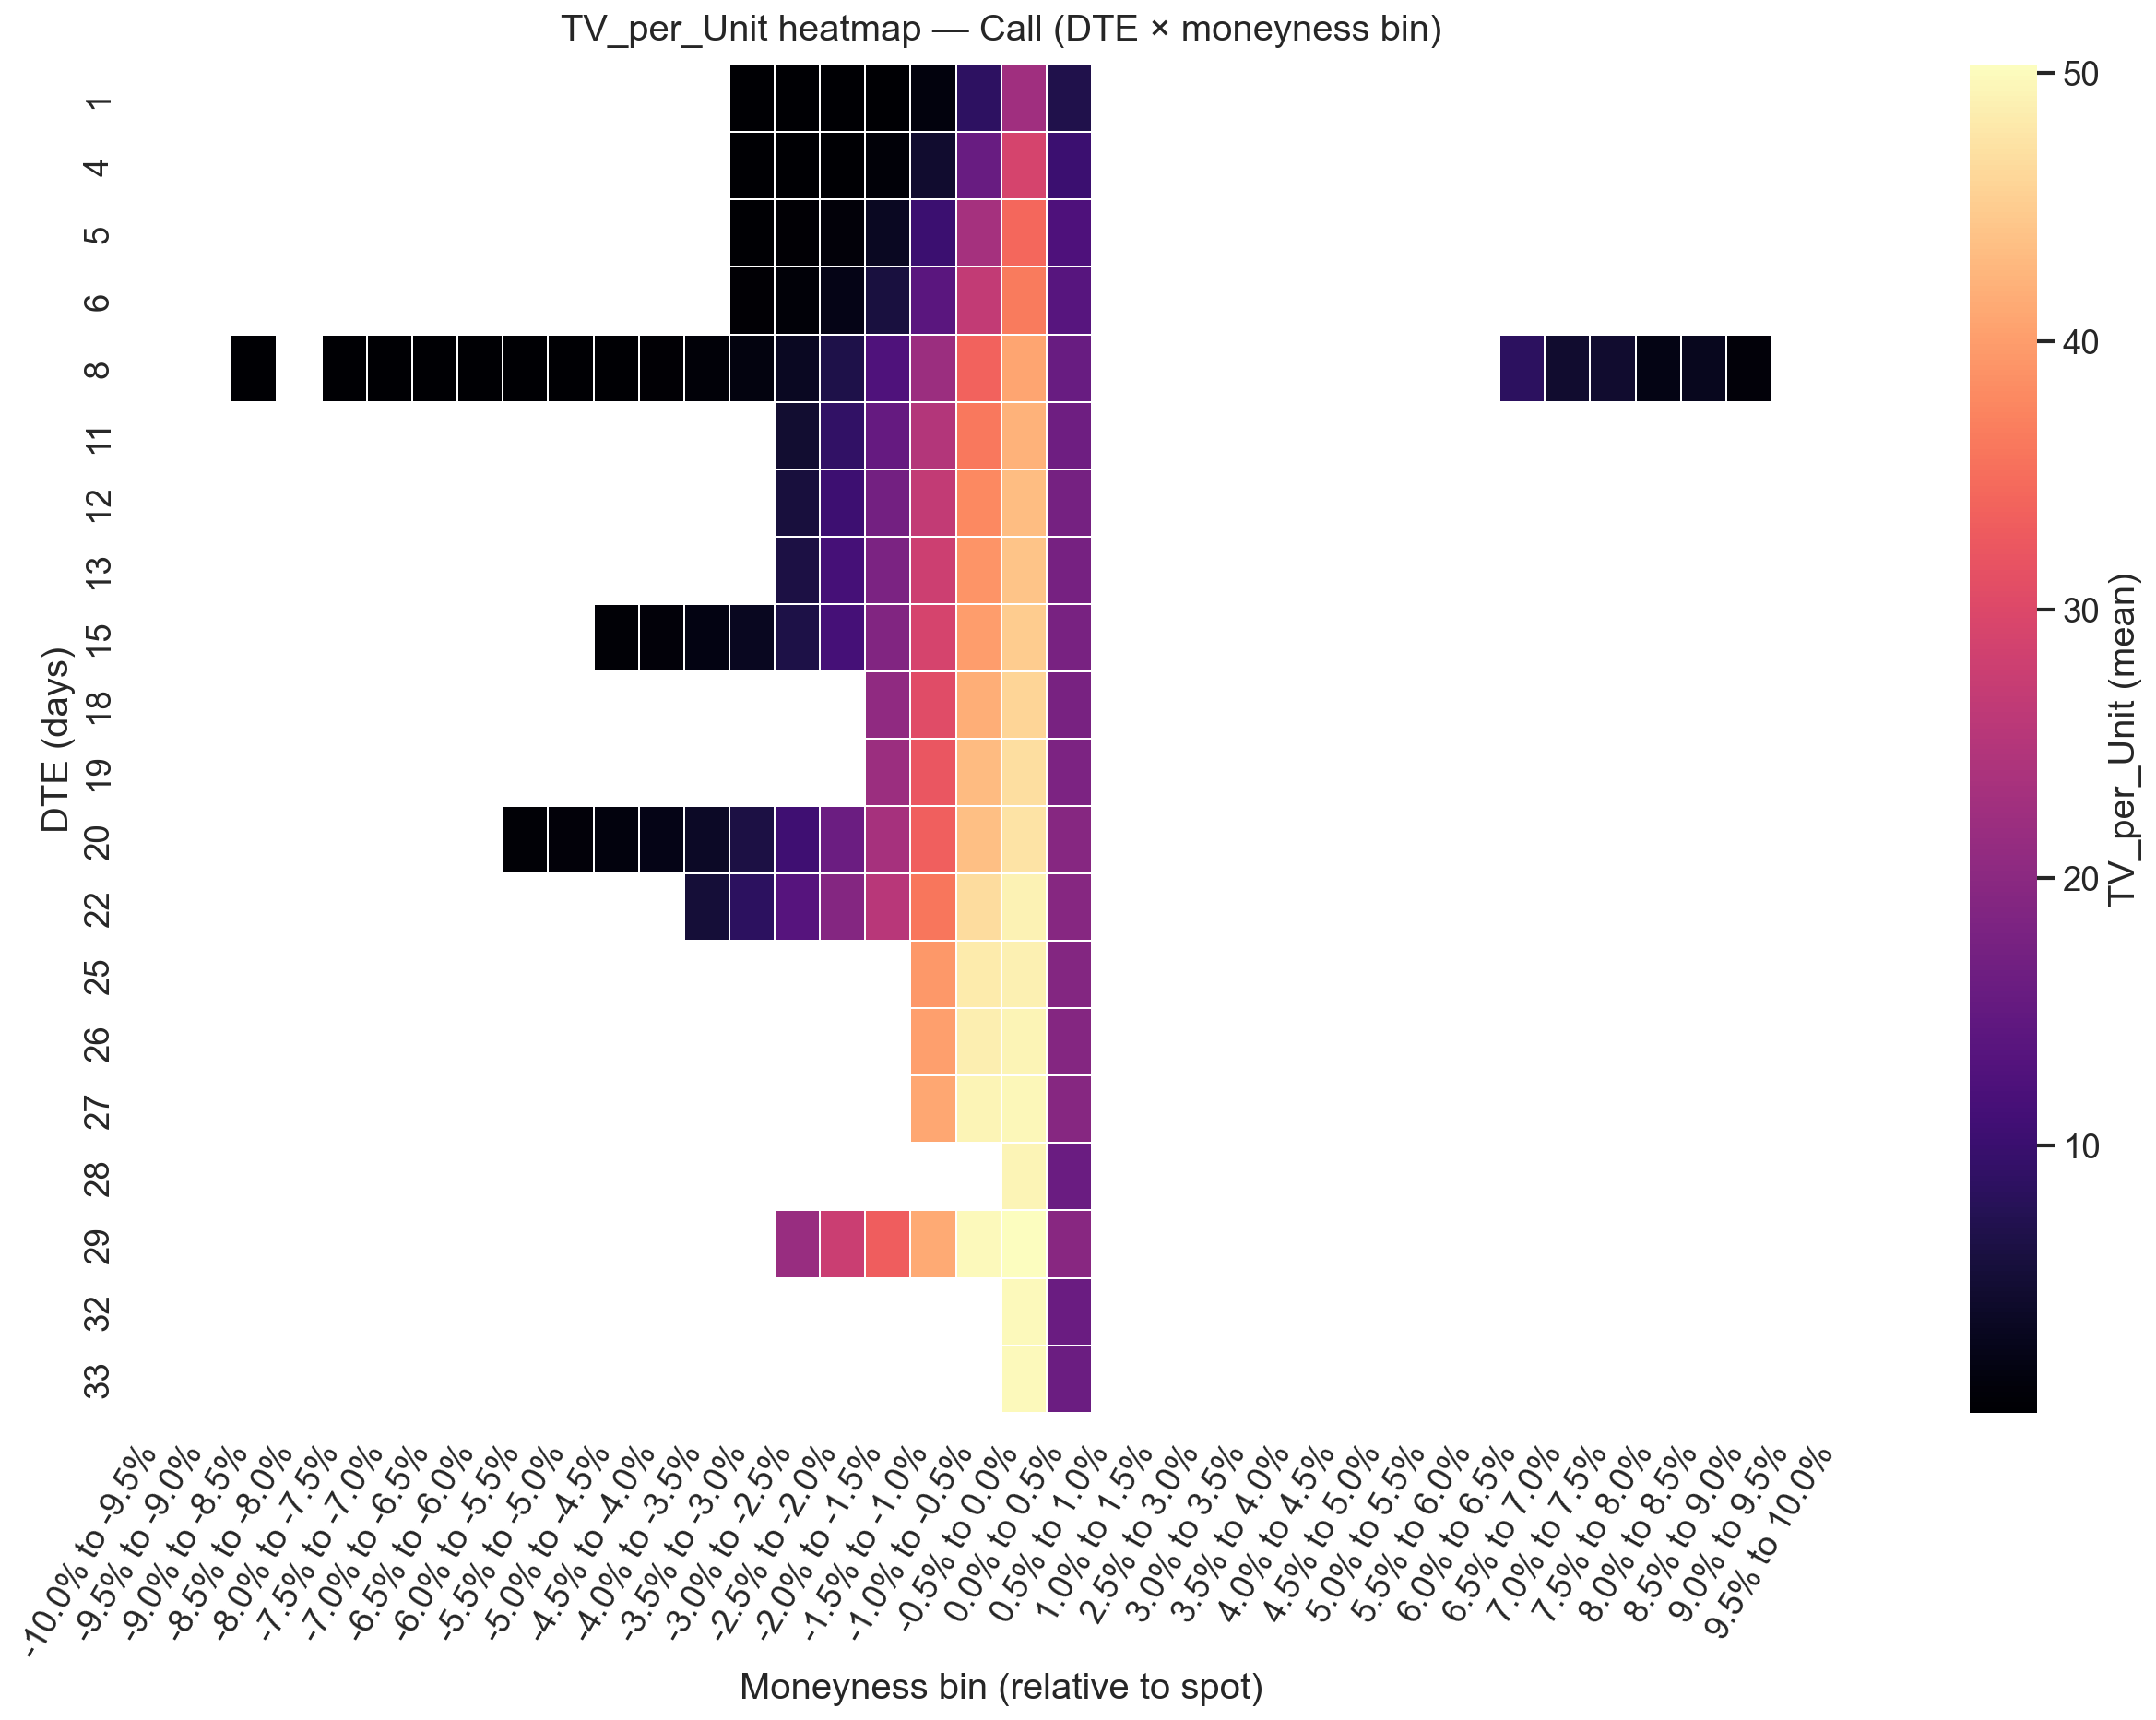

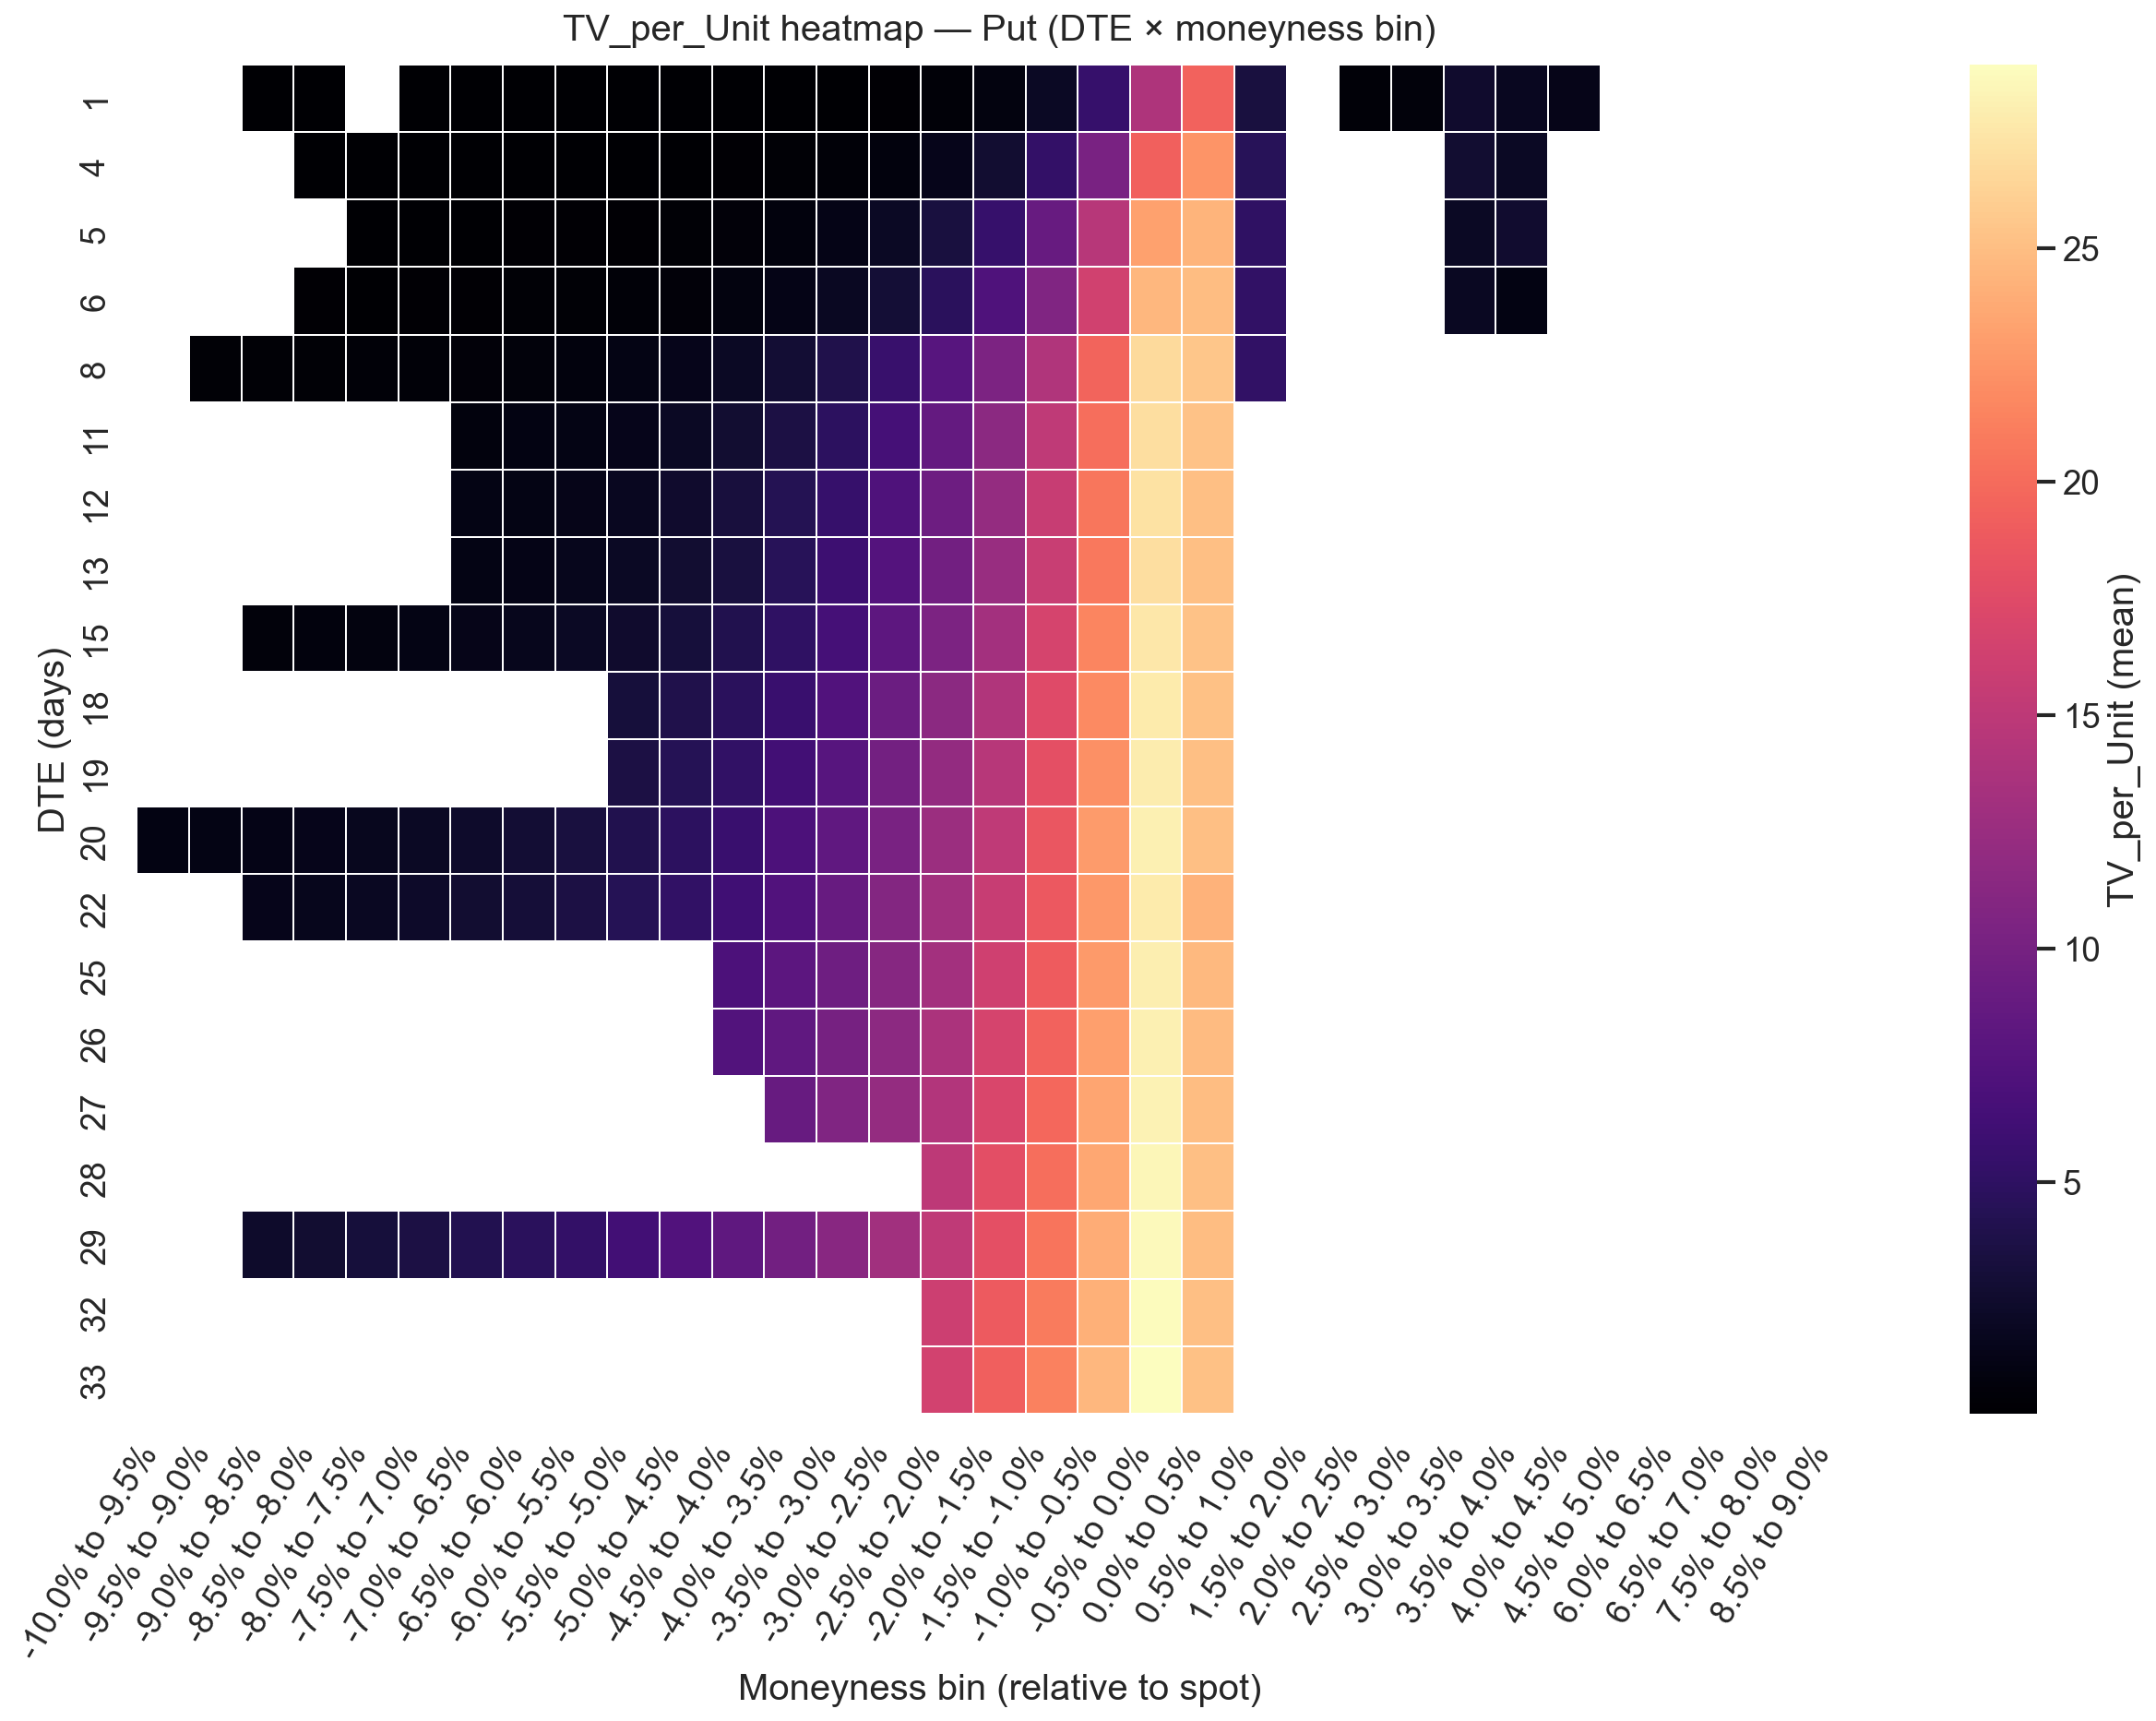

In [19]:

types = f["Type"].dropna().unique().tolist()

for t in types:
    grid, counts = grid_tvpu(f, t, agg=AGG, min_count=MIN_COUNT)
    plt.figure(figsize=(16, 12))
    ax = sns.heatmap(
        grid, cmap="magma", linewidths=0.1, linecolor="white",
        cbar_kws={"label": f"TV_per_Unit ({AGG})"}
    )
    ax.set_title(f"TV_per_Unit heatmap — {t} (DTE × moneyness bin)", pad=12)
    ax.set_xlabel("Moneyness bin (relative to spot)")
    ax.set_ylabel("DTE (days)")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()


In [16]:
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39995 entries, 0 to 39994
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Strike          39995 non-null  int64   
 1   Moneyness       39995 non-null  float64 
 2   Delta           39995 non-null  float64 
 3   Type            39995 non-null  object  
 4   DTE             39995 non-null  int64   
 5   WIDTH           39995 non-null  int64   
 6   EXTRINSIC       39995 non-null  float64 
 7   SpreadWidthPts  39995 non-null  int64   
 8   StepNum         39995 non-null  Int64   
 9   TV_per_Unit     39995 non-null  float64 
 10  moneyness_bin   39995 non-null  category
dtypes: Int64(1), category(1), float64(4), int64(4), object(1)
memory usage: 3.1+ MB


Filtered rows: 920
    Strike WIDTH  DTE  EXTRINSIC  Type
3     6850   100    4      255.0  Call
31    6875    50    4      145.0  Call
36    6875    75    4      885.0  Call
41    6875   100    4     1260.0  Call
109   6900    25    4     1080.0  Call


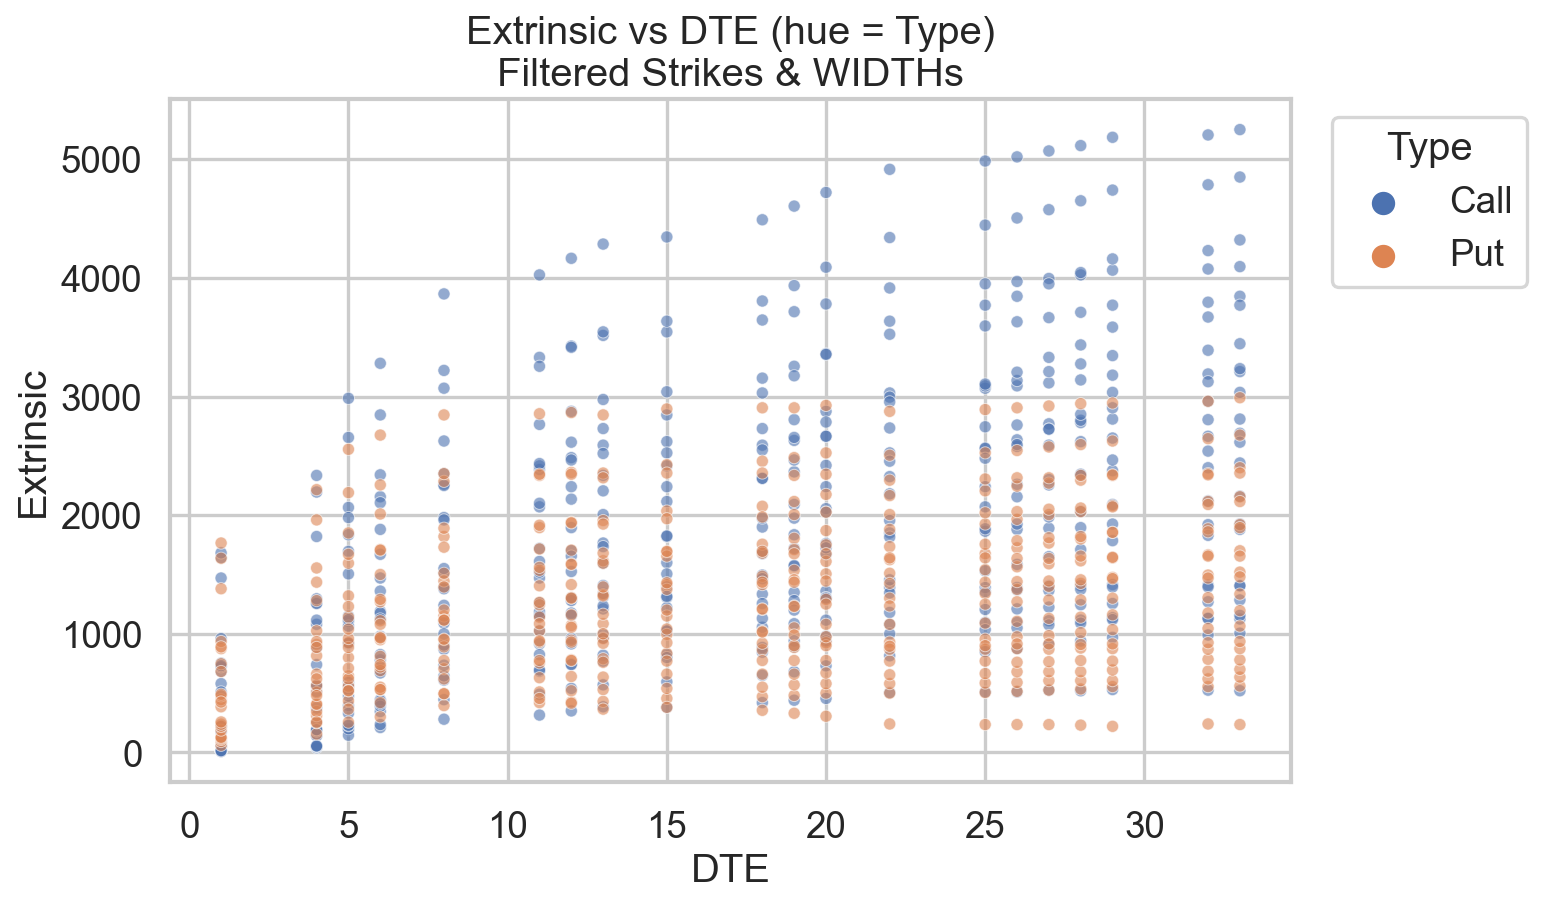

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


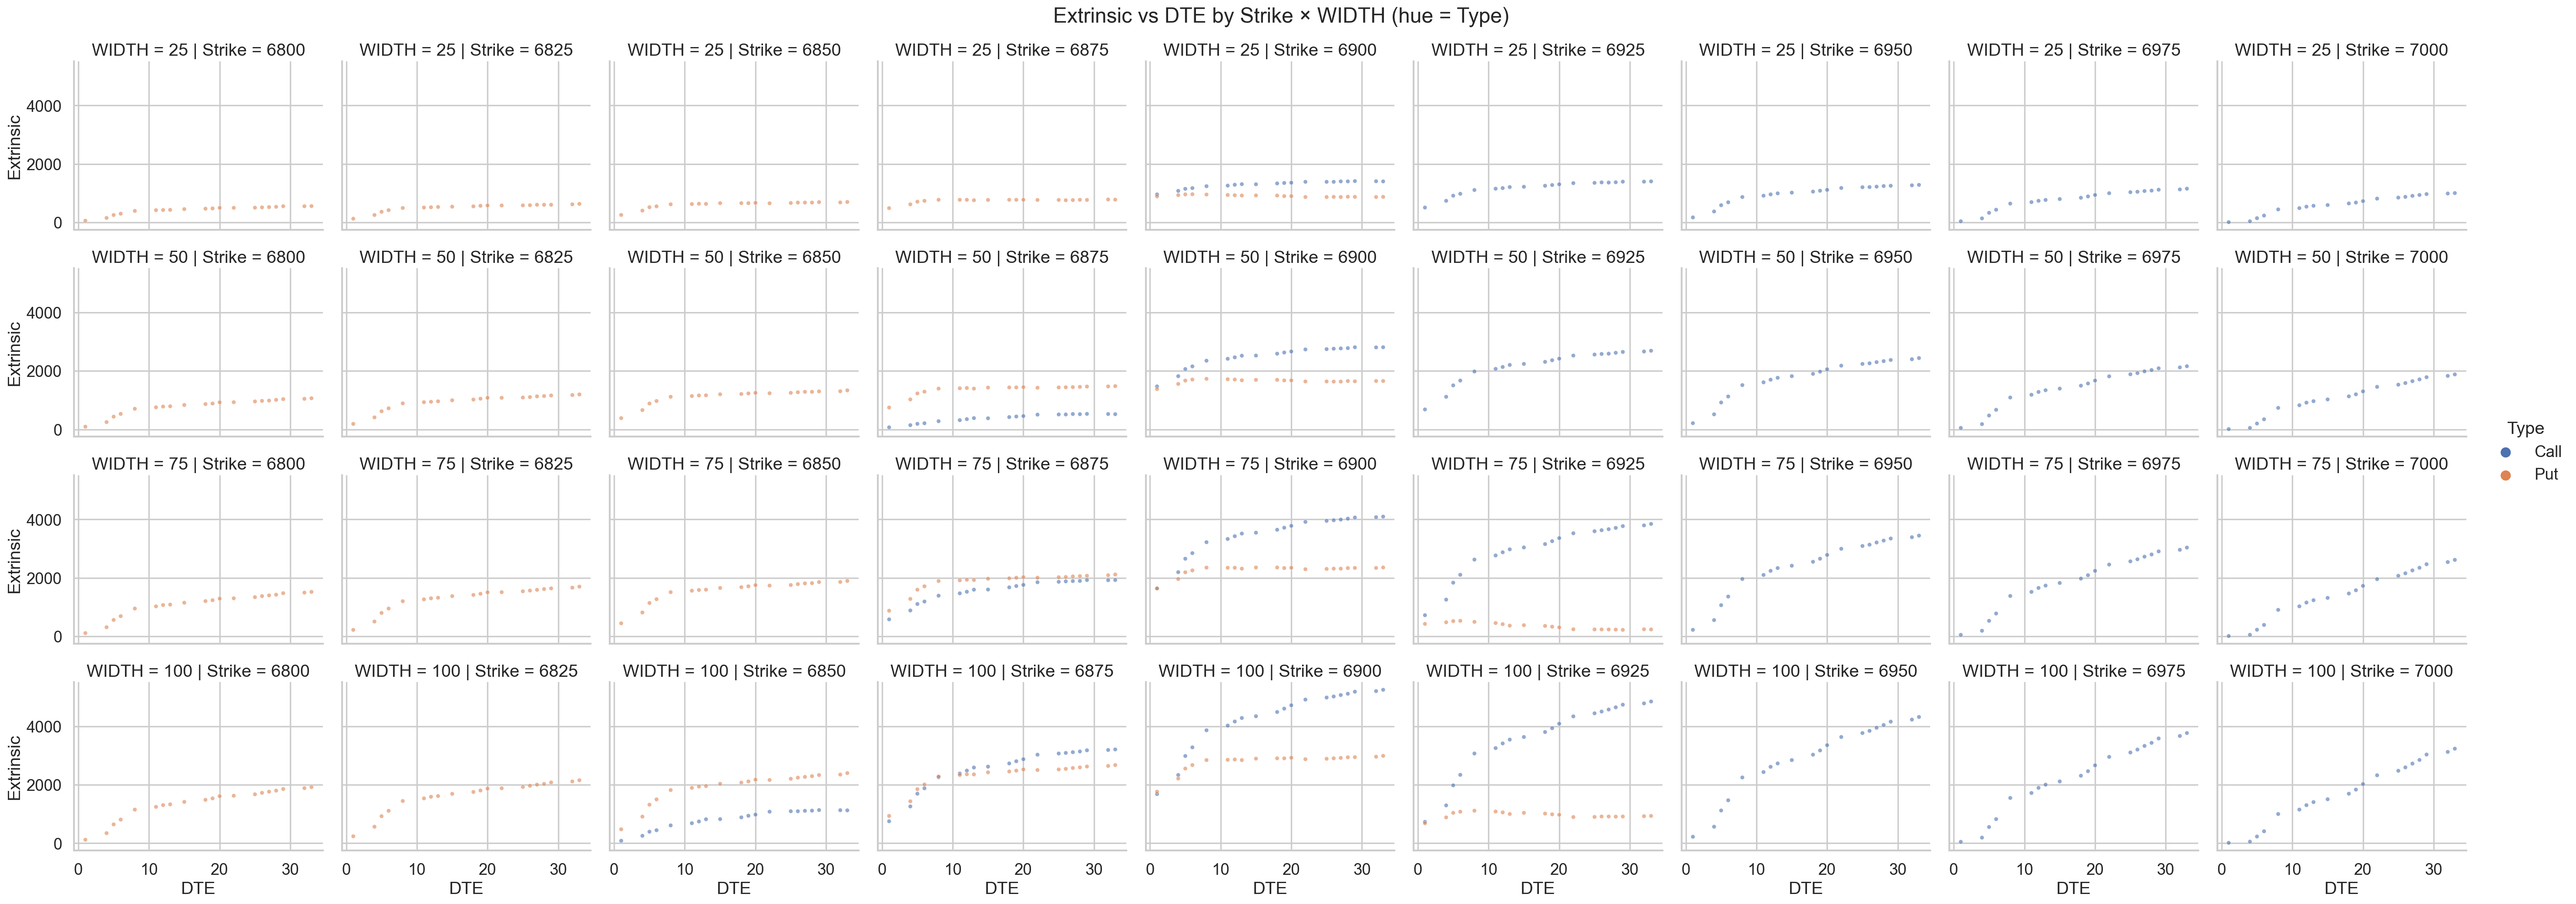

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


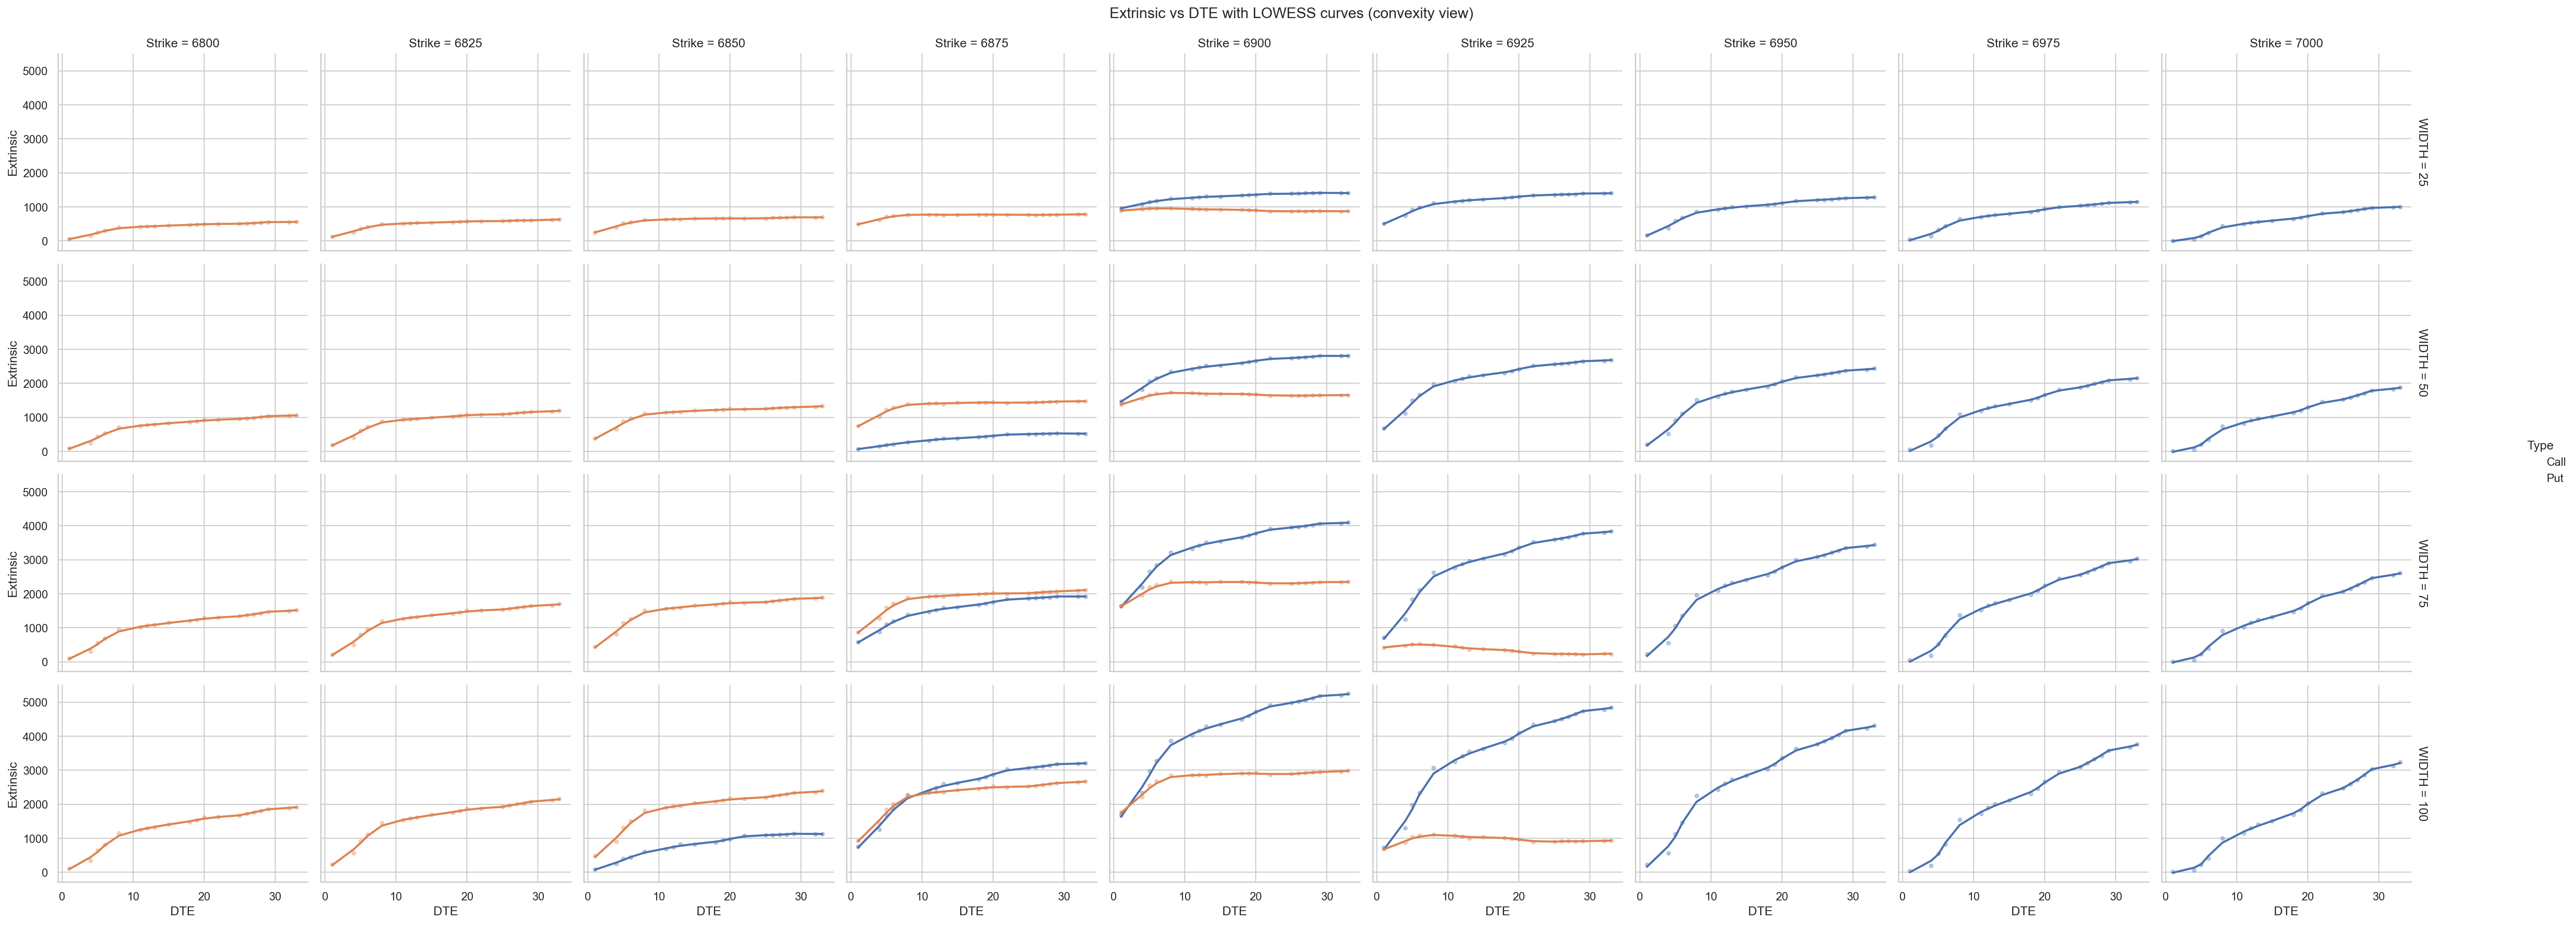

In [30]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Filter: selected Strikes and WIDTHs ---
strikes = [6800, 6825, 6850, 6875, 6900, 6925, 6950, 6975, 7000]
widths  = [25, 50, 75, 100]

# Defensive copy
df = f.copy()

# Filter
g = df[df['Strike'].isin(strikes) & df['WIDTH'].isin(widths)].copy()

# Optional: sort categories for consistent panel layout
g['Strike'] = pd.Categorical(g['Strike'], categories=sorted(strikes), ordered=True)
g['WIDTH']  = pd.Categorical(g['WIDTH'],  categories=sorted(widths),  ordered=True)

print(f"Filtered rows: {len(g)}")
print(g[['Strike','WIDTH','DTE','EXTRINSIC','Type']].head())

# --- 2) Simple scatter: Extrinsic vs DTE, hue by Type ---
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=g,
    x='DTE', y='EXTRINSIC',
    hue='Type',
    alpha=0.6, s=30
)
ax.set_title('Extrinsic vs DTE (hue = Type)\nFiltered Strikes & WIDTHs')
ax.set_xlabel('DTE')
ax.set_ylabel('Extrinsic')
plt.legend(title='Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 3) (Optional) Panel view for convexity “field lines” ---
# Rows = WIDTH, Cols = Strike, points colored by Type.
g2 = sns.relplot(
    data=g,
    x='DTE', y='EXTRINSIC',
    hue='Type',
    col='Strike',
    row='WIDTH',
    kind='scatter',
    height=3.2, aspect=1.25,
    alpha=0.6, s=18
)
g2.set_axis_labels('DTE', 'Extrinsic')
g2.set_titles(row_template='WIDTH = {row_name}', col_template='Strike = {col_name}')
plt.suptitle('Extrinsic vs DTE by Strike × WIDTH (hue = Type)', y=1.02)
plt.show()

# --- 4) (Optional) Add smoothed trend per Type to see curvature ---
# Use lowess smoothing; requires statsmodels; if unavailable, skip or use seaborn lineplot with 'estimator'='mean'.
try:
    import statsmodels.api as sm
    # Lowess per panel and Type
    sns.set(style='whitegrid')
    g3 = sns.FacetGrid(
        g, col='Strike', row='WIDTH', hue='Type',
        height=3.0, aspect=1.25, margin_titles=True, sharex=True, sharey=True
    )
    def lowess_plot(data, color, **kwargs):
        # sort by DTE to get a proper line
        d = data[['DTE','EXTRINSIC']].dropna().sort_values('DTE')
        if len(d) >= 10:
            z = sm.nonparametric.lowess(endog=d['EXTRINSIC'], exog=d['DTE'], frac=0.25, it=0)
            plt.plot(z[:,0], z[:,1], color=color, lw=2)
        # scatter on top
        plt.scatter(d['DTE'], d['EXTRINSIC'], color=color, alpha=0.35, s=12)
    g3.map_dataframe(lowess_plot)
    g3.add_legend(title='Type')
    g3.set_axis_labels('DTE', 'Extrinsic')
    g3.set_titles(row_template='WIDTH = {row_name}', col_template='Strike = {col_name}')
    plt.suptitle('Extrinsic vs DTE with LOWESS curves (convexity view)', y=1.02)
    plt.show()
except Exception as e:
    print("Skipping LOWESS (statsmodels not available):", e)
    # Fallback: mean trend lines per Type
    g4 = sns.relplot(
        data=g, x='DTE', y='EXTRINSIC',
        hue='Type', col='Strike', row='WIDTH',
        kind='line', estimator='mean', errorbar=None, height=3.0, aspect=1.25
    )
    g4.set_axis_labels('DTE', 'Extrinsic (mean)')
    g4.set_titles(row_template='WIDTH = {row_name}', col_template='Strike = {col_name}')
    plt.suptitle('Extrinsic vs DTE mean trend (fallback without LOWESS)', y=1.02)
    plt.show()


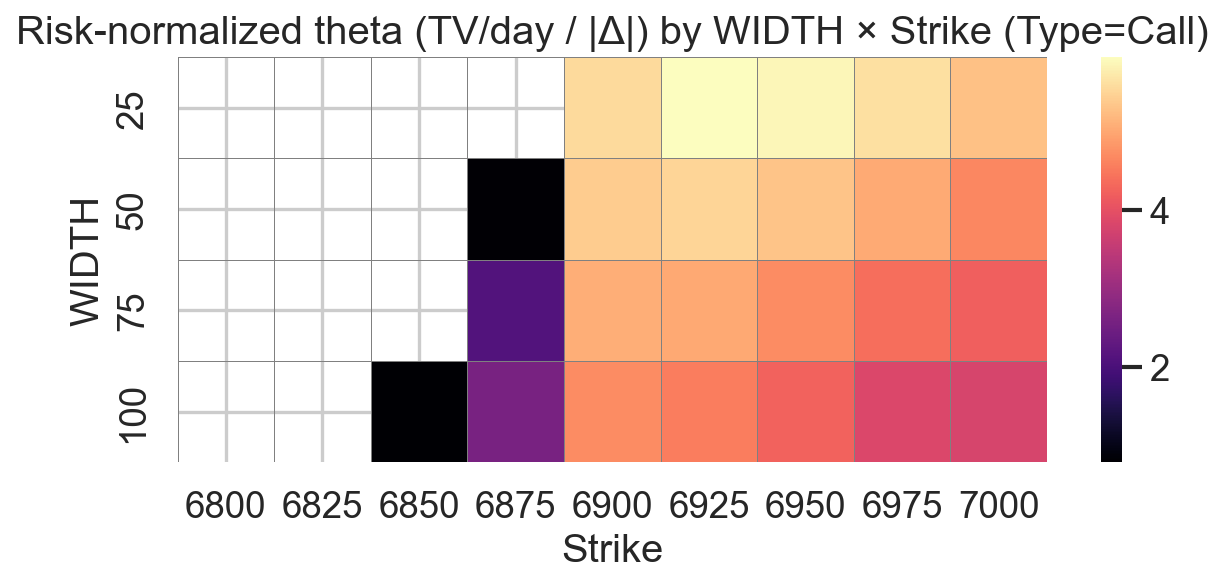

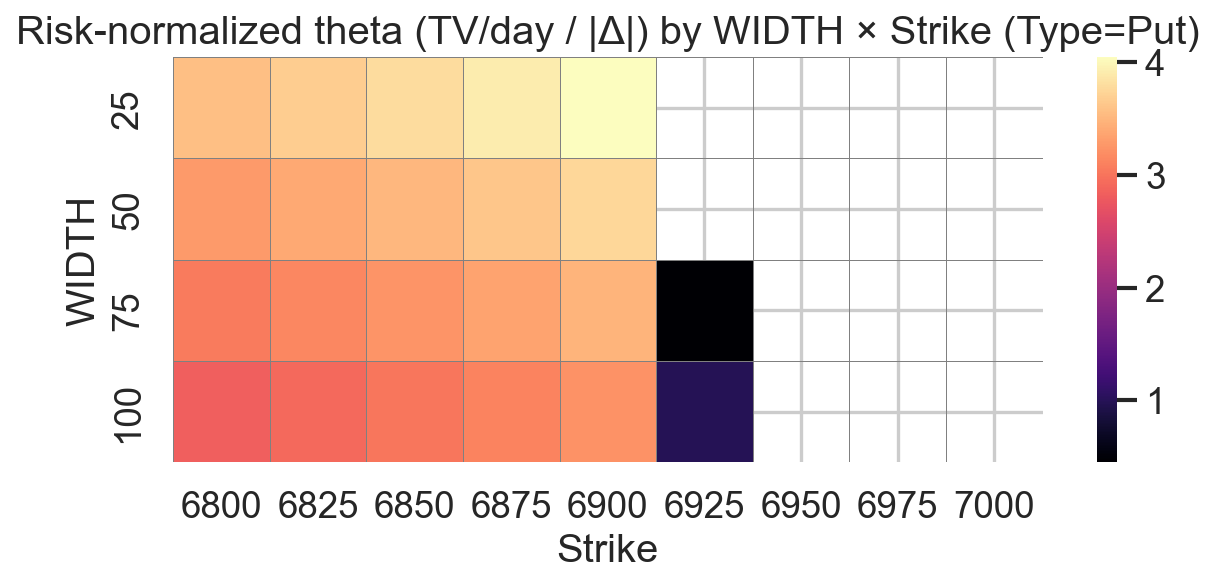

In [34]:

# Example: risk-normalized theta by delta
rn = (g.groupby(['Type','Strike','WIDTH'])[['TV_per_Unit_day','Delta']]
        .median().reset_index())
rn['RN_theta'] = rn['TV_per_Unit_day'] / rn['Delta'].abs().replace(0, np.nan)

for t in rn['Type'].unique():
    sub = rn[rn['Type']==t]
    pivot = sub.pivot(index='WIDTH', columns='Strike', values='RN_theta')
    plt.figure(figsize=(8,4))
    sns.heatmap(pivot, cmap='magma', linewidths=0.4, linecolor='gray')
    plt.title(f"Risk-normalized theta (TV/day / |Δ|) by WIDTH × Strike (Type={t})")
    plt.xlabel('Strike'); plt.ylabel('WIDTH'); plt.tight_layout(); plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


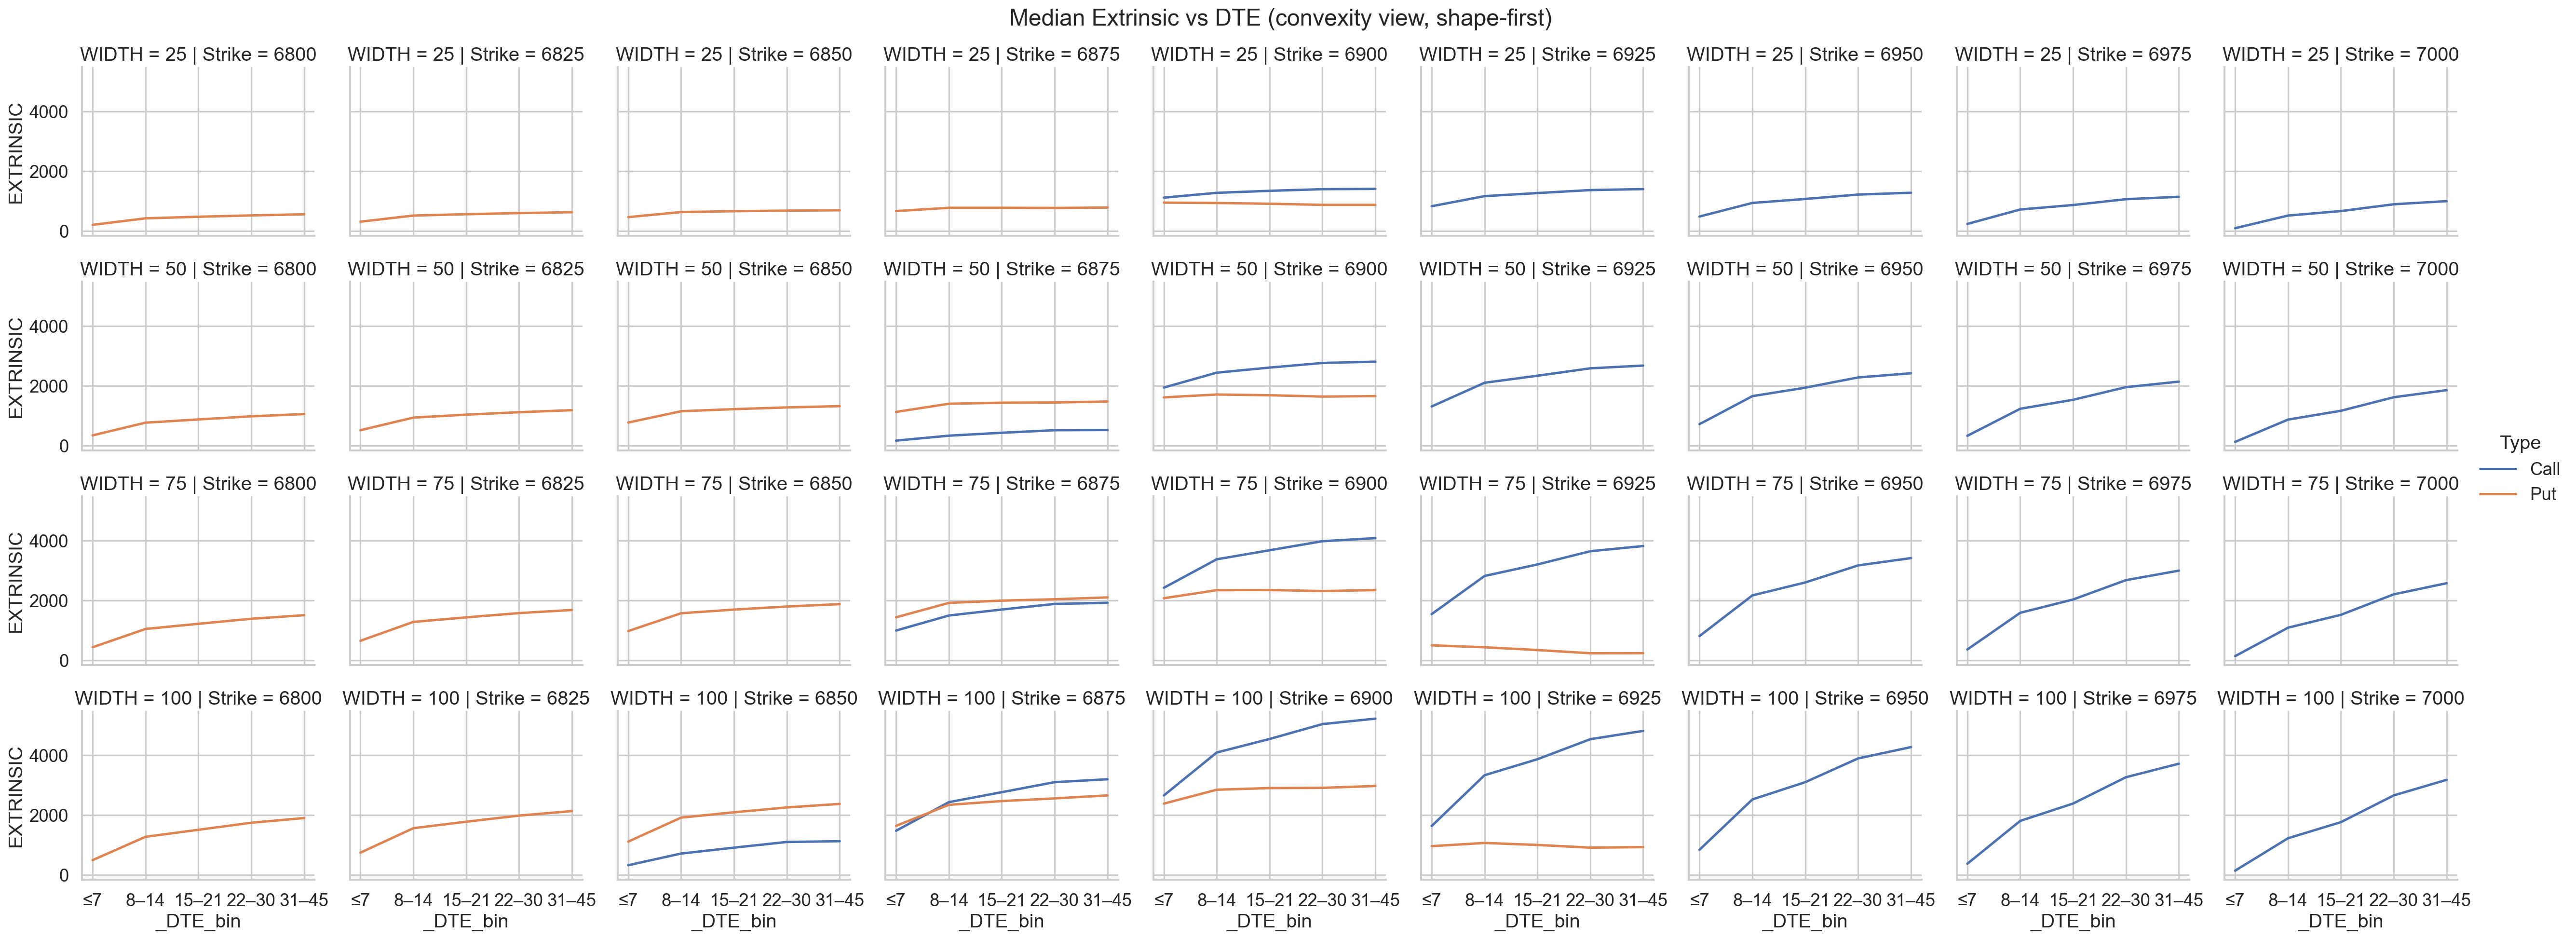

In [35]:

med = (g.groupby(['Type','Strike','WIDTH','_DTE_bin'])['EXTRINSIC']
         .median().reset_index())

sns.relplot(
    data=med, x='_DTE_bin', y='EXTRINSIC',
    hue='Type', col='Strike', row='WIDTH',
    kind='line', errorbar=None, height=3.0, aspect=1.2
)
plt.suptitle('Median Extrinsic vs DTE (convexity view, shape-first)', y=1.02)
plt.show()
